# <center> Майнор "Интеллектуальный анализ данных" </center>

# <center> Курс "Современные методы машинного обучения" </center>

# <center> Лабораторная работа №1. Image Classification. </center>

В данной лабораторной работе вам предлагается обучить модель на основе нейронной сети для распознавания рукописных букв английского алфавита.

## Данные

Данные представлены двумя датасетами: обучающим (`train`) и тестовым (`test`). Изображения для каждого датасета находятся в `images.zip`.  
  
Обучающая выборка состоит из 65000 изображений - по 2500 изображений для каждой буквы.  
Тестовая выборка состоит из 13000 изображений - по 500 изображений для каждой буквы.  
  
Все изображения - монохромные (но в формате RGB), размерности $28 \times 28$ пикселей, в формате JPEG. 
В названии каждого файла содержатся буква, которая представлена на изображении, и уникальный номер изображения: `a_00002.jpg`.  
  
**NB:** Все изображения представлены в перевернутом виде, для корректного отображения их нужно сначала транспонировать. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [17]:
pic = plt.imread('C:\\Users\\admin\\Desktop\\dataset\\train\\a\\a_00002.jpg')
print(pic.shape)

(28, 28, 3)


In [51]:
pic = np.transpose(pic, axes=(1, 0, 2))

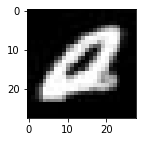

In [52]:
plt.figure(figsize=(2,2))
plt.imshow(pic)
plt.show()

## Imports

In [2]:
import time
import os
from PIL import Image
import torchvision
from torchvision import transforms, datasets
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import pandas as pd
import torch.optim as optim
import torch

## Creating Dataset

In [3]:
TRAIN_PATH = "C:\\Users\\admin\\Desktop\\dataset\\train\\"
TEST_PATH = "C:\\Users\\admin\\Desktop\\dataset\\test\\"
def get_learning_data(path):
    compose = transforms.Compose([transforms.Lambda(lambda x: np.transpose(x, axes=(1, 0, 2))),
                                  transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                  transforms.Grayscale(num_output_channels=1), transforms.Lambda(lambda x: x.float())])
    length = 0
    x_value = torch.Tensor()
    y_value = list()
    for root, dirs, files in os.walk(path):
        for f in files:
            y_value.append(ord(f[0]) - ord('a'))
            x_value = torch.cat((x_value, compose(Image.open(os.path.join(root, f)))), 0)
            length += 1 
    y_value = torch.tensor(y_value, dtype=torch.long)
    return length, x_value, y_value

In [4]:
class LettersDataset(torch.utils.data.Dataset):
    def __init__(self, path):
        self.len, self.x, self.y = get_learning_data(path)
        
    def __getitem__(self, idx):
        return self.x[idx] , self.y[idx]
    
    def __len__(self):
        return self.len

In [5]:

train, val = LettersDataset(TRAIN_PATH), LettersDataset(TEST_PATH)

c:\users\admin\pycharmprojects\iadh\venv\lib\site-packages\torchvision\transforms\functional.py:74: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


In [118]:
# CHECK
BATCH_SIZE = 128
train.__getitem__(1)
train_loader = torch.utils.data.DataLoader(train, batch_size=16, shuffle=True, pin_memory=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val, batch_size=16, shuffle=True, pin_memory=True, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Основные задания

Ваша задача - создать и обучить модель на основе нейронной сети, которая будет предсказывать букву на картинке.  
Обучение необходимо проводить на данных из `train`, качество модели проверять на данных из `test`.  
Целевая метрика - accuracy.  
Для моделирования необходимо использовать `pytorch`.

### Задание 1  
  
*Вес в общей оценке - 0.35*  
  
1. Постройте и обучите модели с 2-мя и 3-мя полносвязными (dense) скрытыми слоями.  
При моделировании необходимо попробовать разные параметры нейронной сети - число нейронов на каждом слое, learning rate, batch size, функции активации, регуляризации и т.д. Оцените качество моделей с различными параметрами, проведите сравнительный анализ. 
2. Для наилучшей модели постройте confusion matrix результатов предсказаний модели на тестовых данных.  
Насколько равномерно обучилась ваша модель? Приведите буквы с самой лучшей и с самой худшей точностью детекции.
3. Найдите 10 пар букв, которые чаще всего путаются между собой, дайте возможное объяснение. Приведите примеры с картинками, которые были детектированы с ошибкой.
4. Возьмите первую букву вашей фамилии и укажите её точность детекции. С какими буквами ваша модель чаще всего путает эту букву?     

### Models

In [66]:
!pip install tqdm

You should consider upgrading via the 'c:\users\admin\pycharmprojects\iadh\venv\scripts\python.exe -m pip install --upgrade pip' command.


In [6]:
import torch.nn.functional as F
from collections import OrderedDict
from tqdm.auto import tqdm

In [7]:
models_2layers = (
    nn.Sequential(nn.Flatten(),             
                  nn.Linear(28 * 28, 128),  
                  nn.ReLU(),             
                  nn.Linear(128, 26)),
    nn.Sequential(nn.Flatten(),             
                  nn.Linear(28 * 28, 128),  
                  nn.Sigmoid(),             
                  nn.Linear(128, 26)),
    nn.Sequential(nn.Flatten(),             
                  nn.Linear(28 * 28, 256),  
                  nn.Tanh(),             
                  nn.Linear(256, 26))
)

lrs_list = (0.003, 0.009, 0.055)
epochs_list = (5, 10, 15)
batches = (16, 32, 64, 128)

In [8]:
def main_train(model, optimizer, n_epochs, train_dataloader, val_dataloader, device):
    print(model.to(device))
    for epoch in range(1, n_epochs + 1):
        # training
        for x_train, y_train in tqdm(train_dataloader):
            x_train = x_train.to(device)
            y_train = y_train.to(device)
            y_pred = model(x_train)
            # y_pred = y_pred.type(torch.LongTensor)
            loss = F.cross_entropy(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # validation
        if epoch % 2 == 0:
            val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_val, y_val in tqdm(val_dataloader):
                    x_val = x_val.to(device)
                    y_val = y_val.to(device)
                    y_pred = model(x_val)
                    loss = F.cross_entropy(y_pred, y_val)
                    val_loss.append(loss.cpu().numpy())
                    val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).cpu().numpy().tolist())
            # print metrics
            print(f"Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}")

def model_train(models, lrs, n_epochs_list, batches, train_data, val_data):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for model in models:
        for lr in lrs:
            print("LR: ", lr)
            layers_optimizer = torch.optim.SGD(model.parameters(), lr=lr)
            for batch in batches:
                print("Batch size: ", batch)
                train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch, shuffle=True, pin_memory=True)
                val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch, shuffle=True, pin_memory=True)
                for n_epochs in n_epochs_list:
                    main_train(model, layers_optimizer, n_epochs, train_loader, val_loader, device)    

In [9]:
# Train with 2 layers
model_train(models_2layers, lrs_list, epochs_list, batches, train, val)

LR:  0.003
Batch size:  16
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 1.0829122066497803, accuracy: 0.6841538461538461


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 0.912457287311554, accuracy: 0.7365384615384616


  0%|          | 0/4063 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 0.7246865630149841, accuracy: 0.7895384615384615


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 0.6425876617431641, accuracy: 0.8131538461538461


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 6, loss: 0.5890865325927734, accuracy: 0.8263846153846154


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 8, loss: 0.5405519008636475, accuracy: 0.8396923076923077


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 10, loss: 0.511110782623291, accuracy: 0.8491538461538461
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 0.4887658655643463, accuracy: 0.8540769230769231


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 0.47563549876213074, accuracy: 0.8548461538461538


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 6, loss: 0.4555940330028534, accuracy: 0.8606923076923076


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 8, loss: 0.4458664059638977, accuracy: 0.8643076923076923


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 10, loss: 0.4281851649284363, accuracy: 0.8702307692307693


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 12, loss: 0.4229283630847931, accuracy: 0.8699230769230769


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 14, loss: 0.41309553384780884, accuracy: 0.8721538461538462


  0%|          | 0/4063 [00:00<?, ?it/s]

Batch size:  32
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.40332815051078796, accuracy: 0.8789230769230769


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.4012228846549988, accuracy: 0.8763846153846154


  0%|          | 0/2032 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.39835527539253235, accuracy: 0.8743076923076923


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.39331334829330444, accuracy: 0.8776923076923077


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 0.39020928740501404, accuracy: 0.8798461538461538


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 0.3893989324569702, accuracy: 0.8816153846153846


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 0.39270487427711487, accuracy: 0.8782307692307693
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.3886667788028717, accuracy: 0.8801538461538462


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.38465413451194763, accuracy: 0.8823846153846154


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 0.38417425751686096, accuracy: 0.8809230769230769


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 0.38146963715553284, accuracy: 0.8819230769230769


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 0.3802121579647064, accuracy: 0.8833846153846154


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 12, loss: 0.37855562567710876, accuracy: 0.8839230769230769


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 14, loss: 0.38201162219047546, accuracy: 0.8832307692307693


  0%|          | 0/2032 [00:00<?, ?it/s]

Batch size:  64
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.3732875883579254, accuracy: 0.8826923076923077


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.3715582489967346, accuracy: 0.8857692307692308


  0%|          | 0/1016 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.3709200620651245, accuracy: 0.8851538461538462


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.37561652064323425, accuracy: 0.8856923076923077


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 0.37220606207847595, accuracy: 0.886


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 0.37164267897605896, accuracy: 0.8854615384615384


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 0.37380728125572205, accuracy: 0.8846923076923077
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.37186866998672485, accuracy: 0.8854615384615384


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.369853138923645, accuracy: 0.8860769230769231


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 0.36900076270103455, accuracy: 0.8863846153846154


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 0.36905437707901, accuracy: 0.8852307692307693


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 0.36912307143211365, accuracy: 0.8858461538461538


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 12, loss: 0.37164145708084106, accuracy: 0.8853076923076924


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 14, loss: 0.36734840273857117, accuracy: 0.8863846153846154


  0%|          | 0/1016 [00:00<?, ?it/s]

Batch size:  128
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.3678046464920044, accuracy: 0.8872307692307693


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.36696135997772217, accuracy: 0.8865384615384615


  0%|          | 0/508 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.36887288093566895, accuracy: 0.8856923076923077


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.3670825660228729, accuracy: 0.8856923076923077


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 0.36646005511283875, accuracy: 0.8865384615384615


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 0.3667851984500885, accuracy: 0.8867692307692308


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 0.3669285774230957, accuracy: 0.8865384615384615
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.3680555820465088, accuracy: 0.8863076923076924


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.3666887879371643, accuracy: 0.8863846153846154


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 0.36757567524909973, accuracy: 0.8866923076923077


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 0.3680293560028076, accuracy: 0.8858461538461538


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 0.36686959862709045, accuracy: 0.8866923076923077


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 12, loss: 0.3669782876968384, accuracy: 0.8856923076923077


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 14, loss: 0.3662101626396179, accuracy: 0.8858461538461538


  0%|          | 0/508 [00:00<?, ?it/s]

LR:  0.009
Batch size:  16
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 0.4242212176322937, accuracy: 0.8685384615384616


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 0.40740036964416504, accuracy: 0.8780769230769231


  0%|          | 0/4063 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 0.39974942803382874, accuracy: 0.8743846153846154


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 0.4101082682609558, accuracy: 0.8736153846153846


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 6, loss: 0.4012734293937683, accuracy: 0.878


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 8, loss: 0.4126224219799042, accuracy: 0.8757692307692307


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 10, loss: 0.402037113904953, accuracy: 0.8789230769230769
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 0.4000530540943146, accuracy: 0.8853846153846154


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 0.41931843757629395, accuracy: 0.8711538461538462


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 6, loss: 0.4327733516693115, accuracy: 0.8758461538461538


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 8, loss: 0.423317015171051, accuracy: 0.8731538461538462


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 10, loss: 0.4265061020851135, accuracy: 0.8787692307692307


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 12, loss: 0.4141678810119629, accuracy: 0.8794615384615385


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 14, loss: 0.42039451003074646, accuracy: 0.8830769230769231


  0%|          | 0/4063 [00:00<?, ?it/s]

Batch size:  32
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.4014810025691986, accuracy: 0.8875384615384615


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.41255971789360046, accuracy: 0.8848461538461538


  0%|          | 0/2032 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.4111573398113251, accuracy: 0.8864615384615384


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.42189285159111023, accuracy: 0.8818461538461538


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 0.41122543811798096, accuracy: 0.8846153846153846


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 0.4171166718006134, accuracy: 0.887


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 0.4217105209827423, accuracy: 0.8832307692307693
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.4165685474872589, accuracy: 0.8854615384615384


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.41992509365081787, accuracy: 0.8860769230769231


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 0.4225741922855377, accuracy: 0.8866153846153846


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 0.4278467297554016, accuracy: 0.8821538461538462


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 0.4296828806400299, accuracy: 0.882


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 12, loss: 0.43151894211769104, accuracy: 0.8833846153846154


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 14, loss: 0.4595552384853363, accuracy: 0.8798461538461538


  0%|          | 0/2032 [00:00<?, ?it/s]

Batch size:  64
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.4254433810710907, accuracy: 0.8873846153846154


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.4348965585231781, accuracy: 0.886


  0%|          | 0/1016 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.43149271607398987, accuracy: 0.8878461538461538


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.430590957403183, accuracy: 0.8883846153846154


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 0.4444997310638428, accuracy: 0.8872307692307693


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 0.43585410714149475, accuracy: 0.8865384615384615


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 0.4369337856769562, accuracy: 0.8869230769230769
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.4350013732910156, accuracy: 0.8876153846153846


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.44302529096603394, accuracy: 0.8843076923076924


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 0.441295325756073, accuracy: 0.8865384615384615


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 0.4425819218158722, accuracy: 0.8846153846153846


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 0.44526156783103943, accuracy: 0.8855384615384615


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 12, loss: 0.4477851390838623, accuracy: 0.8843076923076924


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 14, loss: 0.4483620822429657, accuracy: 0.8866153846153846


  0%|          | 0/1016 [00:00<?, ?it/s]

Batch size:  128
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.44489586353302, accuracy: 0.8870769230769231


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.44731980562210083, accuracy: 0.887


  0%|          | 0/508 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.44768640398979187, accuracy: 0.8856923076923077


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.4474095404148102, accuracy: 0.8871538461538462


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 0.44999751448631287, accuracy: 0.887


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 0.44776812195777893, accuracy: 0.8873846153846154


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 0.44956696033477783, accuracy: 0.8855384615384615
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.4500765800476074, accuracy: 0.8858461538461538


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.4504307508468628, accuracy: 0.8850769230769231


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 0.4501165747642517, accuracy: 0.8860769230769231


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 0.45013678073883057, accuracy: 0.8851538461538462


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 0.4537193775177002, accuracy: 0.8862307692307693


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 12, loss: 0.45247238874435425, accuracy: 0.8866923076923077


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 14, loss: 0.4547760486602783, accuracy: 0.8863076923076924


  0%|          | 0/508 [00:00<?, ?it/s]

LR:  0.055
Batch size:  16
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 0.579072892665863, accuracy: 0.835


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 0.5751194357872009, accuracy: 0.8436153846153847


  0%|          | 0/4063 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 0.550560474395752, accuracy: 0.8541538461538462


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 0.543022632598877, accuracy: 0.8606153846153846


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 6, loss: 0.5204629302024841, accuracy: 0.8691538461538462


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 8, loss: 0.5989974141120911, accuracy: 0.8616153846153846


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 10, loss: 0.605341374874115, accuracy: 0.8505384615384616
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 0.6260324120521545, accuracy: 0.8546153846153847


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 0.5886701345443726, accuracy: 0.8633076923076923


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 6, loss: 0.6602060794830322, accuracy: 0.8581538461538462


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 8, loss: 0.6474059224128723, accuracy: 0.8653076923076923


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 10, loss: 0.6269723176956177, accuracy: 0.8689230769230769


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 12, loss: 0.7306821942329407, accuracy: 0.8534615384615385


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 14, loss: 0.7056272029876709, accuracy: 0.8557692307692307


  0%|          | 0/4063 [00:00<?, ?it/s]

Batch size:  32
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.5881965160369873, accuracy: 0.8796923076923077


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.6135980486869812, accuracy: 0.8766153846153846


  0%|          | 0/2032 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.6156420707702637, accuracy: 0.8782307692307693


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.6433661580085754, accuracy: 0.8800769230769231


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 0.6400876641273499, accuracy: 0.8790769230769231


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 0.6646302342414856, accuracy: 0.8756153846153846


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 0.6688185930252075, accuracy: 0.8765384615384615
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.6652986407279968, accuracy: 0.88


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.6797740459442139, accuracy: 0.8806153846153846


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 0.7229152321815491, accuracy: 0.8743846153846154


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 0.7093151807785034, accuracy: 0.8773846153846154


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 0.7208197116851807, accuracy: 0.8734615384615385


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 12, loss: 0.7211012840270996, accuracy: 0.8736153846153846


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 14, loss: 0.7257559895515442, accuracy: 0.878


  0%|          | 0/2032 [00:00<?, ?it/s]

Batch size:  64
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.7253735065460205, accuracy: 0.8776923076923077


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.7243760228157043, accuracy: 0.8796153846153846


  0%|          | 0/1016 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.7346704602241516, accuracy: 0.8788461538461538


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.7393146753311157, accuracy: 0.8779230769230769


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 0.7439126372337341, accuracy: 0.8777692307692307


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 0.7452943325042725, accuracy: 0.8763846153846154


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 0.7479881644248962, accuracy: 0.875
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.7562252879142761, accuracy: 0.878


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.7644131183624268, accuracy: 0.8776923076923077


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 0.7624927759170532, accuracy: 0.8776923076923077


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 0.7667438387870789, accuracy: 0.8765384615384615


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 0.770186722278595, accuracy: 0.8798461538461538


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 12, loss: 0.7948940396308899, accuracy: 0.8746923076923077


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 14, loss: 0.7803624272346497, accuracy: 0.8763846153846154


  0%|          | 0/1016 [00:00<?, ?it/s]

Batch size:  128
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.7821600437164307, accuracy: 0.8769230769230769


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.7837174534797668, accuracy: 0.8776923076923077


  0%|          | 0/508 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.7862622141838074, accuracy: 0.8778461538461538


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.7902902364730835, accuracy: 0.8777692307692307


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 0.7895969152450562, accuracy: 0.8770769230769231


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 0.794428288936615, accuracy: 0.8773076923076923


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 0.7935230135917664, accuracy: 0.8777692307692307
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.7999897599220276, accuracy: 0.8783076923076923


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.7976130843162537, accuracy: 0.8770769230769231


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 0.7971490025520325, accuracy: 0.8763846153846154


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 0.8006826043128967, accuracy: 0.8766153846153846


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 0.8040385246276855, accuracy: 0.877


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 12, loss: 0.8075752854347229, accuracy: 0.8774615384615385


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 14, loss: 0.8045909404754639, accuracy: 0.8773076923076923


  0%|          | 0/508 [00:00<?, ?it/s]

LR:  0.003
Batch size:  16
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 1.978931188583374, accuracy: 0.5301538461538462


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 1.4741111993789673, accuracy: 0.6018461538461538


  0%|          | 0/4063 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 1.225907802581787, accuracy: 0.6533846153846153


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 1.141885757446289, accuracy: 0.6746923076923077


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 6, loss: 1.0817742347717285, accuracy: 0.6931538461538461


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 8, loss: 1.03346586227417, accuracy: 0.706


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 10, loss: 0.9930469989776611, accuracy: 0.7143846153846154
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 0.9566570520401001, accuracy: 0.7256153846153847


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 0.9250824451446533, accuracy: 0.7343846153846154


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 6, loss: 0.8963292837142944, accuracy: 0.7426153846153846


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 8, loss: 0.8693652749061584, accuracy: 0.7496153846153846


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 10, loss: 0.8437172770500183, accuracy: 0.7570769230769231


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 12, loss: 0.8215364217758179, accuracy: 0.7636923076923077


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 14, loss: 0.7999765872955322, accuracy: 0.7685384615384615


  0%|          | 0/4063 [00:00<?, ?it/s]

Batch size:  32
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.7801116108894348, accuracy: 0.7735384615384615


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.7712358832359314, accuracy: 0.7756153846153846


  0%|          | 0/2032 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.7558404207229614, accuracy: 0.7816153846153846


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.7472965121269226, accuracy: 0.7843076923076923


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 0.7392321825027466, accuracy: 0.7855384615384615


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 0.7309774160385132, accuracy: 0.7883846153846154


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 0.7239077091217041, accuracy: 0.791
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.7159874439239502, accuracy: 0.7925384615384615


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.7082746624946594, accuracy: 0.7946923076923077


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 0.7021015286445618, accuracy: 0.7956923076923077


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 0.694922924041748, accuracy: 0.7988461538461539


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 0.6891128420829773, accuracy: 0.8


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 12, loss: 0.6807106137275696, accuracy: 0.8018461538461539


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 14, loss: 0.6739758253097534, accuracy: 0.8033846153846154


  0%|          | 0/2032 [00:00<?, ?it/s]

Batch size:  64
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.6673554182052612, accuracy: 0.8054615384615385


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.6645789742469788, accuracy: 0.8062307692307692


  0%|          | 0/1016 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.6584325432777405, accuracy: 0.8077692307692308


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.6563327312469482, accuracy: 0.8084615384615385


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 0.6567056179046631, accuracy: 0.8096923076923077


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 0.6500492691993713, accuracy: 0.81


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 0.6513368487358093, accuracy: 0.8104615384615385
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.6482697129249573, accuracy: 0.8108461538461539


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.6449412107467651, accuracy: 0.8116153846153846


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 0.6404937505722046, accuracy: 0.8127692307692308


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 0.6414065361022949, accuracy: 0.8133846153846154


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 0.6390983462333679, accuracy: 0.813076923076923


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 12, loss: 0.6317164301872253, accuracy: 0.815


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 14, loss: 0.6332106590270996, accuracy: 0.8153076923076923


  0%|          | 0/1016 [00:00<?, ?it/s]

Batch size:  128
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.6271588206291199, accuracy: 0.8163846153846154


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.6267396807670593, accuracy: 0.8168461538461539


  0%|          | 0/508 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.6244004368782043, accuracy: 0.8173846153846154


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.6237592697143555, accuracy: 0.8174615384615385


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 0.6218498349189758, accuracy: 0.8175384615384615


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 0.6209143996238708, accuracy: 0.8178461538461539


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 0.6197002530097961, accuracy: 0.8185384615384615
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.6181898713111877, accuracy: 0.8191538461538461


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.6176074743270874, accuracy: 0.8192307692307692


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 0.6170370578765869, accuracy: 0.8192307692307692


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 0.6159747838973999, accuracy: 0.8196923076923077


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 0.6136917471885681, accuracy: 0.8206153846153846


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 12, loss: 0.6121576428413391, accuracy: 0.8202307692307692


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 14, loss: 0.6115789413452148, accuracy: 0.8212307692307692


  0%|          | 0/508 [00:00<?, ?it/s]

LR:  0.009
Batch size:  16
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 0.5923565626144409, accuracy: 0.8258461538461539


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 0.5661110877990723, accuracy: 0.8335384615384616


  0%|          | 0/4063 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 0.5416823029518127, accuracy: 0.8407692307692308


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 0.5250616669654846, accuracy: 0.8453846153846154


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 6, loss: 0.5124645233154297, accuracy: 0.8481538461538461


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 8, loss: 0.4993765950202942, accuracy: 0.8512307692307692


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 10, loss: 0.4930812418460846, accuracy: 0.8539230769230769
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 0.4807729423046112, accuracy: 0.8585384615384616


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 0.4740346074104309, accuracy: 0.8601538461538462


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 6, loss: 0.4635545015335083, accuracy: 0.8630769230769231


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 8, loss: 0.45474594831466675, accuracy: 0.8653846153846154


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 10, loss: 0.4520314037799835, accuracy: 0.8633846153846154


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 12, loss: 0.4448665678501129, accuracy: 0.8657692307692307


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 14, loss: 0.4394899010658264, accuracy: 0.8669230769230769


  0%|          | 0/4063 [00:00<?, ?it/s]

Batch size:  32
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.43205147981643677, accuracy: 0.8680769230769231


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.4304947853088379, accuracy: 0.8678461538461538


  0%|          | 0/2032 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.42650777101516724, accuracy: 0.869


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.4232715964317322, accuracy: 0.8703846153846154


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 0.42299821972846985, accuracy: 0.8723846153846154


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 0.4210048317909241, accuracy: 0.8723076923076923


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 0.41956695914268494, accuracy: 0.8709230769230769
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.4171621799468994, accuracy: 0.8728461538461538


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.41634824872016907, accuracy: 0.8739230769230769


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 0.4142945408821106, accuracy: 0.8720769230769231


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 0.41234609484672546, accuracy: 0.8734615384615385


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 0.4100772440433502, accuracy: 0.8746153846153846


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 12, loss: 0.40890201926231384, accuracy: 0.8756923076923077


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 14, loss: 0.4078718423843384, accuracy: 0.8761538461538462


  0%|          | 0/2032 [00:00<?, ?it/s]

Batch size:  64
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.4074398875236511, accuracy: 0.8755384615384615


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.4041086733341217, accuracy: 0.876


  0%|          | 0/1016 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.40247493982315063, accuracy: 0.876


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.4030579924583435, accuracy: 0.8759230769230769


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 0.4026901423931122, accuracy: 0.8761538461538462


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 0.40787994861602783, accuracy: 0.8768461538461538


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 0.40060365200042725, accuracy: 0.8770769230769231
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.39866796135902405, accuracy: 0.8778461538461538


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.39831453561782837, accuracy: 0.8788461538461538


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 0.3988775312900543, accuracy: 0.8774615384615385


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 0.3982715904712677, accuracy: 0.8771538461538462


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 0.39794158935546875, accuracy: 0.8776923076923077


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 12, loss: 0.3972304165363312, accuracy: 0.8777692307692307


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 14, loss: 0.39525315165519714, accuracy: 0.878


  0%|          | 0/1016 [00:00<?, ?it/s]

Batch size:  128
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.39617758989334106, accuracy: 0.8793846153846154


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.39609917998313904, accuracy: 0.8783076923076923


  0%|          | 0/508 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.3953380584716797, accuracy: 0.8786153846153846


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.395906925201416, accuracy: 0.8784615384615385


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 0.3948774039745331, accuracy: 0.8785384615384615


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 0.3940940499305725, accuracy: 0.8788461538461538


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 0.3942256569862366, accuracy: 0.8787692307692307
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.3940226137638092, accuracy: 0.8784615384615385


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.39428672194480896, accuracy: 0.8798461538461538


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 0.39357492327690125, accuracy: 0.8790769230769231


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 0.39326032996177673, accuracy: 0.8793076923076923


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 0.3931218385696411, accuracy: 0.8799230769230769


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 12, loss: 0.3925515115261078, accuracy: 0.8790769230769231


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 14, loss: 0.3937385678291321, accuracy: 0.8793846153846154


  0%|          | 0/508 [00:00<?, ?it/s]

LR:  0.055
Batch size:  16
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 0.4174033999443054, accuracy: 0.8696923076923077


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 0.4198918342590332, accuracy: 0.8697692307692307


  0%|          | 0/4063 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 0.39642012119293213, accuracy: 0.875


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 0.4017484188079834, accuracy: 0.8706153846153846


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 6, loss: 0.4284813702106476, accuracy: 0.8631538461538462


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 8, loss: 0.40011852979660034, accuracy: 0.874


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 10, loss: 0.4093872010707855, accuracy: 0.8716923076923077
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 0.40313297510147095, accuracy: 0.8733076923076923


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 0.4042111337184906, accuracy: 0.8753076923076923


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 6, loss: 0.42975112795829773, accuracy: 0.8617692307692307


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 8, loss: 0.40065374970436096, accuracy: 0.8765384615384615


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 10, loss: 0.4077660143375397, accuracy: 0.8737692307692307


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 12, loss: 0.41203346848487854, accuracy: 0.8744615384615385


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 14, loss: 0.41954320669174194, accuracy: 0.8714615384615385


  0%|          | 0/4063 [00:00<?, ?it/s]

Batch size:  32
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.4060211479663849, accuracy: 0.8756153846153846


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.40670281648635864, accuracy: 0.8803846153846154


  0%|          | 0/2032 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.4150528907775879, accuracy: 0.8732307692307693


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.41524526476860046, accuracy: 0.8768461538461538


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 0.4110131561756134, accuracy: 0.8769230769230769


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 0.4125742018222809, accuracy: 0.8794615384615385


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 0.41921645402908325, accuracy: 0.8737692307692307
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.41709667444229126, accuracy: 0.8762307692307693


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.42345669865608215, accuracy: 0.8744615384615385


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 0.4283665418624878, accuracy: 0.8722307692307693


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 0.42193737626075745, accuracy: 0.8763076923076923


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 0.430869996547699, accuracy: 0.8746153846153846


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 12, loss: 0.43754342198371887, accuracy: 0.8736153846153846


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 14, loss: 0.428345650434494, accuracy: 0.8776153846153846


  0%|          | 0/2032 [00:00<?, ?it/s]

Batch size:  64
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.42271581292152405, accuracy: 0.876


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.42309045791625977, accuracy: 0.8785384615384615


  0%|          | 0/1016 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.42953434586524963, accuracy: 0.8781538461538462


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.4274289011955261, accuracy: 0.8749230769230769


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 0.4302598536014557, accuracy: 0.8766153846153846


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 0.4278601408004761, accuracy: 0.8775384615384615


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 0.42741289734840393, accuracy: 0.8764615384615385
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.4304978549480438, accuracy: 0.878


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.42953914403915405, accuracy: 0.876


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 0.43672776222229004, accuracy: 0.8749230769230769


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 0.43379461765289307, accuracy: 0.8753846153846154


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 0.4336259365081787, accuracy: 0.8759230769230769


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 12, loss: 0.43351754546165466, accuracy: 0.8771538461538462


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 14, loss: 0.4370560348033905, accuracy: 0.8760769230769231


  0%|          | 0/1016 [00:00<?, ?it/s]

Batch size:  128
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.43604278564453125, accuracy: 0.8754615384615385


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.43707263469696045, accuracy: 0.8770769230769231


  0%|          | 0/508 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.43676358461380005, accuracy: 0.876


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.43877968192100525, accuracy: 0.8763076923076923


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 0.4393441677093506, accuracy: 0.8746153846153846


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 0.4386938214302063, accuracy: 0.8762307692307693


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 0.43876850605010986, accuracy: 0.8758461538461538
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.44181764125823975, accuracy: 0.8761538461538462


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.44112420082092285, accuracy: 0.8763076923076923


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 0.44274699687957764, accuracy: 0.8752307692307693


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 0.44186118245124817, accuracy: 0.8756153846153846


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 0.4413638710975647, accuracy: 0.8763076923076923


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 12, loss: 0.4424959123134613, accuracy: 0.8751538461538462


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 14, loss: 0.44354984164237976, accuracy: 0.875


  0%|          | 0/508 [00:00<?, ?it/s]

LR:  0.003
Batch size:  16
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 1.1000417470932007, accuracy: 0.6797692307692308


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 0.9500018954277039, accuracy: 0.727


  0%|          | 0/4063 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 0.78950035572052, accuracy: 0.7709230769230769


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 0.7033759951591492, accuracy: 0.7964615384615384


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 6, loss: 0.640174388885498, accuracy: 0.8146153846153846


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 8, loss: 0.597406804561615, accuracy: 0.8267692307692308


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 10, loss: 0.5523411631584167, accuracy: 0.8376923076923077
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 0.5238132476806641, accuracy: 0.8475384615384616


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 0.49747446179389954, accuracy: 0.8526923076923076


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 6, loss: 0.47791898250579834, accuracy: 0.8573846153846154


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 8, loss: 0.4610772728919983, accuracy: 0.8627692307692307


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 10, loss: 0.44686630368232727, accuracy: 0.8659230769230769


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 12, loss: 0.4355888366699219, accuracy: 0.8706153846153846


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 14, loss: 0.4228394627571106, accuracy: 0.8726923076923077


  0%|          | 0/4063 [00:00<?, ?it/s]

Batch size:  32
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.40876927971839905, accuracy: 0.8787692307692307


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.40454432368278503, accuracy: 0.8776153846153846


  0%|          | 0/2032 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.4001651108264923, accuracy: 0.8786923076923077


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.3962738513946533, accuracy: 0.8799230769230769


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 0.39223214983940125, accuracy: 0.8811538461538462


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 0.3883155584335327, accuracy: 0.8825384615384615


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 0.3883003294467926, accuracy: 0.8829230769230769
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.38280507922172546, accuracy: 0.8832307692307693


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.380685955286026, accuracy: 0.8833846153846154


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 0.37906336784362793, accuracy: 0.8839230769230769


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 0.3738766610622406, accuracy: 0.8843846153846154


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 0.3725912868976593, accuracy: 0.8852307692307693


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 12, loss: 0.37163910269737244, accuracy: 0.8851538461538462


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 14, loss: 0.369022011756897, accuracy: 0.8856923076923077


  0%|          | 0/2032 [00:00<?, ?it/s]

Batch size:  64
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.3661343455314636, accuracy: 0.8863076923076924


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.3626619279384613, accuracy: 0.8874615384615384


  0%|          | 0/1016 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.36224305629730225, accuracy: 0.8868461538461538


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.3629312813282013, accuracy: 0.888


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 0.35929784178733826, accuracy: 0.8877692307692308


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 0.3622448444366455, accuracy: 0.8879230769230769


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 0.3591393232345581, accuracy: 0.8869230769230769
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.3581753671169281, accuracy: 0.8883076923076924


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.355441153049469, accuracy: 0.8890769230769231


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 0.3570197522640228, accuracy: 0.8882307692307693


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 0.35490888357162476, accuracy: 0.8892307692307693


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 0.35422268509864807, accuracy: 0.8889230769230769


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 12, loss: 0.35722142457962036, accuracy: 0.8889230769230769


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 14, loss: 0.354734867811203, accuracy: 0.8896923076923077


  0%|          | 0/1016 [00:00<?, ?it/s]

Batch size:  128
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.35246095061302185, accuracy: 0.8901538461538462


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.3511958718299866, accuracy: 0.8896923076923077


  0%|          | 0/508 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.3511471152305603, accuracy: 0.8899230769230769


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.3516528904438019, accuracy: 0.8905384615384615


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 0.35047852993011475, accuracy: 0.8897692307692308


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 0.35021165013313293, accuracy: 0.8891538461538462


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 0.35055580735206604, accuracy: 0.8883846153846154
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.3497485816478729, accuracy: 0.8896153846153846


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.35016995668411255, accuracy: 0.8897692307692308


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 0.3486444056034088, accuracy: 0.8907692307692308


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 0.3485744595527649, accuracy: 0.8901538461538462


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 0.3490069508552551, accuracy: 0.8905384615384615


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 12, loss: 0.34853416681289673, accuracy: 0.8913846153846153


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 14, loss: 0.34732332825660706, accuracy: 0.891


  0%|          | 0/508 [00:00<?, ?it/s]

LR:  0.009
Batch size:  16
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 0.36895307898521423, accuracy: 0.8822307692307693


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 0.35208696126937866, accuracy: 0.8862307692307693


  0%|          | 0/4063 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 0.34348100423812866, accuracy: 0.8904615384615384


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 0.34009024500846863, accuracy: 0.8924615384615384


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 6, loss: 0.3490845263004303, accuracy: 0.8864615384615384


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 8, loss: 0.342282235622406, accuracy: 0.8925384615384615


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 10, loss: 0.33487001061439514, accuracy: 0.8938461538461538
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 0.34070393443107605, accuracy: 0.893


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 0.334164559841156, accuracy: 0.8940769230769231


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 6, loss: 0.3380195200443268, accuracy: 0.8906153846153846


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 8, loss: 0.34228867292404175, accuracy: 0.8875384615384615


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 10, loss: 0.34040430188179016, accuracy: 0.8899230769230769


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 12, loss: 0.34496229887008667, accuracy: 0.8923846153846153


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 14, loss: 0.3439651131629944, accuracy: 0.891


  0%|          | 0/4063 [00:00<?, ?it/s]

Batch size:  32
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.3367062211036682, accuracy: 0.8943076923076924


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.3380632996559143, accuracy: 0.8935384615384615


  0%|          | 0/2032 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.3427601754665375, accuracy: 0.8939230769230769


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.34177303314208984, accuracy: 0.8925384615384615


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 0.34547117352485657, accuracy: 0.8915384615384615


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 0.34345683455467224, accuracy: 0.8930769230769231


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 0.34360426664352417, accuracy: 0.8926153846153846
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.34545087814331055, accuracy: 0.8923076923076924


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.34598827362060547, accuracy: 0.8923076923076924


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 0.34672847390174866, accuracy: 0.8912307692307693


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 0.3439168632030487, accuracy: 0.8932307692307693


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 0.34542572498321533, accuracy: 0.8913846153846153


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 12, loss: 0.3462260365486145, accuracy: 0.8922307692307693


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 14, loss: 0.34854283928871155, accuracy: 0.8914615384615384


  0%|          | 0/2032 [00:00<?, ?it/s]

Batch size:  64
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.34821227192878723, accuracy: 0.8936153846153846


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.3507387638092041, accuracy: 0.8916923076923077


  0%|          | 0/1016 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.3492838442325592, accuracy: 0.8912307692307693


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.3490299582481384, accuracy: 0.8925384615384615


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 0.34946897625923157, accuracy: 0.8916923076923077


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 0.34934180974960327, accuracy: 0.8914615384615384


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 0.3513633906841278, accuracy: 0.892
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.34973663091659546, accuracy: 0.8913076923076924


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.35117092728614807, accuracy: 0.8915384615384615


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 0.352813184261322, accuracy: 0.8908461538461538


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 0.3519911766052246, accuracy: 0.8917692307692308


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 0.35059213638305664, accuracy: 0.8931538461538462


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 12, loss: 0.35329580307006836, accuracy: 0.8922307692307693


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 14, loss: 0.351854145526886, accuracy: 0.8934615384615384


  0%|          | 0/1016 [00:00<?, ?it/s]

Batch size:  128
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.3530932068824768, accuracy: 0.8913076923076924


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.35252735018730164, accuracy: 0.8909230769230769


  0%|          | 0/508 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.35344651341438293, accuracy: 0.8916153846153846


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.3529306948184967, accuracy: 0.8929230769230769


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 0.35400068759918213, accuracy: 0.8923076923076924


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 0.3526398837566376, accuracy: 0.8927692307692308


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 0.35416004061698914, accuracy: 0.8906153846153846
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.3554188311100006, accuracy: 0.8902307692307693


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.3554423451423645, accuracy: 0.8926153846153846


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 0.355484277009964, accuracy: 0.8915384615384615


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 0.3543826937675476, accuracy: 0.8922307692307693


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 0.3547965884208679, accuracy: 0.8916153846153846


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 12, loss: 0.3557308316230774, accuracy: 0.892


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 14, loss: 0.3548026978969574, accuracy: 0.8918461538461538


  0%|          | 0/508 [00:00<?, ?it/s]

LR:  0.055
Batch size:  16
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 0.47926950454711914, accuracy: 0.8544615384615385


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 0.5158084630966187, accuracy: 0.8472307692307692


  0%|          | 0/4063 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 0.4651959240436554, accuracy: 0.8611538461538462


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 0.4614326059818268, accuracy: 0.8654615384615385


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 6, loss: 0.46704867482185364, accuracy: 0.869


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 8, loss: 0.4911702573299408, accuracy: 0.8607692307692307


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 10, loss: 0.4651350677013397, accuracy: 0.8719230769230769
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 0.46494293212890625, accuracy: 0.8730769230769231


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 0.4530406892299652, accuracy: 0.8771538461538462


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 6, loss: 0.4815106987953186, accuracy: 0.8686153846153846


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 8, loss: 0.4908604025840759, accuracy: 0.8704615384615385


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 10, loss: 0.5072848200798035, accuracy: 0.864


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 12, loss: 0.5045479536056519, accuracy: 0.8681538461538462


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 14, loss: 0.49398183822631836, accuracy: 0.8786153846153846


  0%|          | 0/4063 [00:00<?, ?it/s]

Batch size:  32
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.4785216152667999, accuracy: 0.8795384615384615


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.4805498421192169, accuracy: 0.8806153846153846


  0%|          | 0/2032 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.4909202754497528, accuracy: 0.8786153846153846


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.48927682638168335, accuracy: 0.8812307692307693


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 0.4909791648387909, accuracy: 0.8814615384615384


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 0.5079784989356995, accuracy: 0.8746153846153846


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 0.4974595010280609, accuracy: 0.8780769230769231
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.5063105821609497, accuracy: 0.8770769230769231


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.5059831142425537, accuracy: 0.879


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 0.5187594294548035, accuracy: 0.8737692307692307


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 0.5073269009590149, accuracy: 0.8786153846153846


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 0.5103205442428589, accuracy: 0.8773076923076923


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 12, loss: 0.5083172917366028, accuracy: 0.8799230769230769


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 14, loss: 0.513141930103302, accuracy: 0.8807692307692307


  0%|          | 0/2032 [00:00<?, ?it/s]

Batch size:  64
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.5164144039154053, accuracy: 0.8781538461538462


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.5114317536354065, accuracy: 0.879


  0%|          | 0/1016 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.5197639465332031, accuracy: 0.8793076923076923


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.5219019651412964, accuracy: 0.8778461538461538


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 0.5170804262161255, accuracy: 0.8791538461538462


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 0.530078649520874, accuracy: 0.8764615384615385


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 0.5203777551651001, accuracy: 0.8786153846153846
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.5195708870887756, accuracy: 0.8789230769230769


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.5199559330940247, accuracy: 0.8804615384615384


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 0.5296762585639954, accuracy: 0.8785384615384615


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 0.5236379504203796, accuracy: 0.8784615384615385


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 0.5233050584793091, accuracy: 0.8783846153846154


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 12, loss: 0.529991626739502, accuracy: 0.8785384615384615


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 14, loss: 0.5259440541267395, accuracy: 0.8798461538461538


  0%|          | 0/1016 [00:00<?, ?it/s]

Batch size:  128
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.5317047238349915, accuracy: 0.8785384615384615


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.5286429524421692, accuracy: 0.8786923076923077


  0%|          | 0/508 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.5320485234260559, accuracy: 0.8785384615384615


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.5291762351989746, accuracy: 0.8795384615384615


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 0.5331447124481201, accuracy: 0.8797692307692307


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 0.5316382050514221, accuracy: 0.8777692307692307


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 0.5379070043563843, accuracy: 0.8773076923076923
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.5343878269195557, accuracy: 0.8794615384615385


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.5317238569259644, accuracy: 0.879


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 0.533392071723938, accuracy: 0.8798461538461538


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 0.5361747741699219, accuracy: 0.8791538461538462


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 0.5386452078819275, accuracy: 0.8773846153846154


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 12, loss: 0.5365601181983948, accuracy: 0.8767692307692307


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 14, loss: 0.5420559644699097, accuracy: 0.8771538461538462


  0%|          | 0/508 [00:00<?, ?it/s]

## Результаты
Наилучшим результатом обладает  следующая 2ух слойная модель:

LR = 0.003

Batch Size = 64

Epoches number = 15

Accuracy = 0.88

Функция активации ReLU

In [ ]:
print()

In [10]:
layers_3_models = (
    nn.Sequential(nn.Flatten(),             
                  nn.Linear(28 * 28, 256),  
                  nn.ReLU(),             
                  nn.Linear(256, 128),
                  nn.ReLU(),
                  nn.Linear(128, 26)), 
    
    nn.Sequential(nn.Flatten(),             
                  nn.Linear(28 * 28, 256),  
                  nn.Sigmoid(),             
                  nn.Linear(256, 128),
                  nn.Sigmoid(),
                  nn.Linear(128, 26)),
        
    nn.Sequential(nn.Flatten(),             
                  nn.Linear(28 * 28, 256),  
                  nn.Tanh(),             
                  nn.Linear(256, 128),
                  nn.Tanh(),
                  nn.Linear(128, 26))
)

In [11]:
model_train(layers_3_models, lrs_list, epochs_list, batches, train, val)

LR:  0.003
Batch size:  16
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 1.116834044456482, accuracy: 0.675


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 0.8701736330986023, accuracy: 0.7446153846153846


  0%|          | 0/4063 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 0.628931999206543, accuracy: 0.8134615384615385


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 0.5458630919456482, accuracy: 0.837


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 6, loss: 0.4852953553199768, accuracy: 0.8546153846153847


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 8, loss: 0.4496503174304962, accuracy: 0.8648461538461538


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 10, loss: 0.42200732231140137, accuracy: 0.8679230769230769
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 0.39840492606163025, accuracy: 0.8786153846153846


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 0.3883233368396759, accuracy: 0.8793846153846154


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 6, loss: 0.3795205354690552, accuracy: 0.8793076923076923


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 8, loss: 0.3622865080833435, accuracy: 0.8862307692307693


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 10, loss: 0.3534979224205017, accuracy: 0.8897692307692308


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 12, loss: 0.3415664732456207, accuracy: 0.8933846153846153


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 14, loss: 0.33991342782974243, accuracy: 0.8924615384615384


  0%|          | 0/4063 [00:00<?, ?it/s]

Batch size:  32
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.32854464650154114, accuracy: 0.8956153846153846


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.32727792859077454, accuracy: 0.8968461538461538


  0%|          | 0/2032 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.3242454528808594, accuracy: 0.8990769230769231


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.34235167503356934, accuracy: 0.892


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 0.32508111000061035, accuracy: 0.8974615384615384


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 0.3252007067203522, accuracy: 0.8977692307692308


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 0.33063313364982605, accuracy: 0.8972307692307693
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.3326547145843506, accuracy: 0.8936153846153846


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.3265089988708496, accuracy: 0.8956923076923077


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 0.31787896156311035, accuracy: 0.8993076923076923


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 0.32280081510543823, accuracy: 0.8996923076923077


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 0.32222262024879456, accuracy: 0.8999230769230769


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 12, loss: 0.3233416974544525, accuracy: 0.8998461538461539


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 14, loss: 0.32180723547935486, accuracy: 0.9006153846153846


  0%|          | 0/2032 [00:00<?, ?it/s]

Batch size:  64
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.3195750415325165, accuracy: 0.9020769230769231


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.3179989755153656, accuracy: 0.9021538461538462


  0%|          | 0/1016 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.32039201259613037, accuracy: 0.9019230769230769


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.32098525762557983, accuracy: 0.9001538461538462


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 0.31771838665008545, accuracy: 0.9019230769230769


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 0.32089412212371826, accuracy: 0.9017692307692308


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 0.3216294050216675, accuracy: 0.9030769230769231
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.3210848271846771, accuracy: 0.8995384615384615


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.3213435113430023, accuracy: 0.9022307692307693


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 0.32167914509773254, accuracy: 0.9022307692307693


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 0.32201850414276123, accuracy: 0.9021538461538462


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 0.3220479488372803, accuracy: 0.9021538461538462


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 12, loss: 0.32703062891960144, accuracy: 0.9013846153846153


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 14, loss: 0.3222421407699585, accuracy: 0.9023846153846153


  0%|          | 0/1016 [00:00<?, ?it/s]

Batch size:  128
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.3239624500274658, accuracy: 0.9008461538461539


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.3234202563762665, accuracy: 0.9025384615384615


  0%|          | 0/508 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.3247877359390259, accuracy: 0.9017692307692308


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.3249393105506897, accuracy: 0.9016153846153846


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 0.32542482018470764, accuracy: 0.9020769230769231


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 0.3263089656829834, accuracy: 0.9020769230769231


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 0.32639288902282715, accuracy: 0.9013076923076923
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.32675901055336, accuracy: 0.9017692307692308


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.3265797197818756, accuracy: 0.9033076923076923


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 0.3260450065135956, accuracy: 0.9016153846153846


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 0.32823681831359863, accuracy: 0.9013846153846153


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 0.32803693413734436, accuracy: 0.9013076923076923


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 12, loss: 0.32701683044433594, accuracy: 0.9023076923076923


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 14, loss: 0.3273855149745941, accuracy: 0.9024615384615384


  0%|          | 0/508 [00:00<?, ?it/s]

LR:  0.009
Batch size:  16
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 0.4016313850879669, accuracy: 0.8843846153846154


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 0.39516812562942505, accuracy: 0.8806923076923077


  0%|          | 0/4063 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 0.3888275921344757, accuracy: 0.8883846153846154


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 0.40946128964424133, accuracy: 0.8857692307692308


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 6, loss: 0.4577690064907074, accuracy: 0.8776923076923077


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 8, loss: 0.3848123252391815, accuracy: 0.8969230769230769


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 10, loss: 0.39311182498931885, accuracy: 0.8944615384615384
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 0.3984748125076294, accuracy: 0.8935384615384615


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 0.42393961548805237, accuracy: 0.8846923076923077


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 6, loss: 0.4396594166755676, accuracy: 0.8825384615384615


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 8, loss: 0.4362417459487915, accuracy: 0.8900769230769231


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 10, loss: 0.4357627034187317, accuracy: 0.8932307692307693


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 12, loss: 0.4403392970561981, accuracy: 0.8945384615384615


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 14, loss: 0.4273822009563446, accuracy: 0.9016153846153846


  0%|          | 0/4063 [00:00<?, ?it/s]

Batch size:  32
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.4276180863380432, accuracy: 0.899


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.42803776264190674, accuracy: 0.9013846153846153


  0%|          | 0/2032 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.43555063009262085, accuracy: 0.9012307692307693


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.4425541162490845, accuracy: 0.8979230769230769


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 0.43667542934417725, accuracy: 0.9023076923076923


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 0.4416561722755432, accuracy: 0.8990769230769231


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 0.4441830813884735, accuracy: 0.8976153846153846
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.45090243220329285, accuracy: 0.8964615384615384


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.45049792528152466, accuracy: 0.9007692307692308


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 0.46007004380226135, accuracy: 0.8969230769230769


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 0.45342350006103516, accuracy: 0.9009230769230769


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 0.4615391492843628, accuracy: 0.8989230769230769


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 12, loss: 0.46869632601737976, accuracy: 0.9006153846153846


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 14, loss: 0.4676794409751892, accuracy: 0.9000769230769231


  0%|          | 0/2032 [00:00<?, ?it/s]

Batch size:  64
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.46489909291267395, accuracy: 0.9018461538461539


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.46894657611846924, accuracy: 0.9003846153846153


  0%|          | 0/1016 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.47330737113952637, accuracy: 0.9005384615384615


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.4788926839828491, accuracy: 0.8983846153846153


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 0.47893404960632324, accuracy: 0.9013076923076923


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 0.47481828927993774, accuracy: 0.8997692307692308


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 0.479390949010849, accuracy: 0.8999230769230769
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.47726166248321533, accuracy: 0.9017692307692308


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.48282182216644287, accuracy: 0.8993846153846153


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 0.47884613275527954, accuracy: 0.9012307692307693


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 0.4903636872768402, accuracy: 0.8994615384615384


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 0.4865231215953827, accuracy: 0.8983076923076924


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 12, loss: 0.4928184449672699, accuracy: 0.9004615384615384


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 14, loss: 0.49477338790893555, accuracy: 0.9006153846153846


  0%|          | 0/1016 [00:00<?, ?it/s]

Batch size:  128
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.4881053566932678, accuracy: 0.9006153846153846


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.48985493183135986, accuracy: 0.9002307692307693


  0%|          | 0/508 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.4942530691623688, accuracy: 0.9004615384615384


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.49152135848999023, accuracy: 0.9001538461538462


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 0.4925972521305084, accuracy: 0.9017692307692308


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 0.49934545159339905, accuracy: 0.9004615384615384


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 0.4991493225097656, accuracy: 0.8985384615384615
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.495421826839447, accuracy: 0.9010769230769231


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.4978678226470947, accuracy: 0.901


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 0.4972616136074066, accuracy: 0.9002307692307693


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 0.5011839866638184, accuracy: 0.8993076923076923


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 0.4968242347240448, accuracy: 0.9006923076923077


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 12, loss: 0.5015779137611389, accuracy: 0.9007692307692308


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 14, loss: 0.5002869963645935, accuracy: 0.9014615384615384


  0%|          | 0/508 [00:00<?, ?it/s]

LR:  0.055
Batch size:  16
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 0.5014306306838989, accuracy: 0.8437692307692307


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 0.45720529556274414, accuracy: 0.8611538461538462


  0%|          | 0/4063 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 0.4488237798213959, accuracy: 0.8683076923076923


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 0.4442569613456726, accuracy: 0.8763846153846154


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 6, loss: 0.43601417541503906, accuracy: 0.8871538461538462


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 8, loss: 0.47207319736480713, accuracy: 0.8782307692307693


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 10, loss: 0.47108194231987, accuracy: 0.8845384615384615
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 0.4872868061065674, accuracy: 0.8803076923076923


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 0.49619653820991516, accuracy: 0.8873076923076924


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 6, loss: 0.5220608711242676, accuracy: 0.8873076923076924


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 8, loss: 0.5736712217330933, accuracy: 0.8813846153846154


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 10, loss: 0.5599123239517212, accuracy: 0.8831538461538462


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 12, loss: 0.5698625445365906, accuracy: 0.883


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 14, loss: 0.5868418216705322, accuracy: 0.8860769230769231


  0%|          | 0/4063 [00:00<?, ?it/s]

Batch size:  32
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.5183939337730408, accuracy: 0.907


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.5330157279968262, accuracy: 0.9057692307692308


  0%|          | 0/2032 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.5663769841194153, accuracy: 0.9056153846153846


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.5823754668235779, accuracy: 0.9056153846153846


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 0.5942577719688416, accuracy: 0.9055384615384615


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 0.6067992448806763, accuracy: 0.906


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 0.6165708303451538, accuracy: 0.9042307692307693
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.6276223659515381, accuracy: 0.9031538461538462


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.647561252117157, accuracy: 0.9040769230769231


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 0.657593846321106, accuracy: 0.9030769230769231


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 0.6648758053779602, accuracy: 0.9023076923076923


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 0.6775635480880737, accuracy: 0.9021538461538462


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 12, loss: 0.6778069734573364, accuracy: 0.9022307692307693


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 14, loss: 0.6867576837539673, accuracy: 0.8996923076923077


  0%|          | 0/2032 [00:00<?, ?it/s]

Batch size:  64
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.6946333050727844, accuracy: 0.9037692307692308


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.7007401585578918, accuracy: 0.9033846153846153


  0%|          | 0/1016 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.7069255113601685, accuracy: 0.9016153846153846


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.7135435938835144, accuracy: 0.902


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 0.7180289626121521, accuracy: 0.9019230769230769


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 0.7179856300354004, accuracy: 0.9019230769230769


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 0.7298533320426941, accuracy: 0.9033846153846153
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.729774534702301, accuracy: 0.9026923076923077


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.7357938885688782, accuracy: 0.9014615384615384


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 0.7398077845573425, accuracy: 0.9033846153846153


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 0.7529341578483582, accuracy: 0.9010769230769231


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 0.7444552183151245, accuracy: 0.9014615384615384


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 12, loss: 0.7510479092597961, accuracy: 0.9010769230769231


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 14, loss: 0.7597905397415161, accuracy: 0.9012307692307693


  0%|          | 0/1016 [00:00<?, ?it/s]

Batch size:  128
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.7648670077323914, accuracy: 0.8999230769230769


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.7650186419487, accuracy: 0.901


  0%|          | 0/508 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.7731655240058899, accuracy: 0.9017692307692308


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.7720031142234802, accuracy: 0.9003846153846153


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 0.775701105594635, accuracy: 0.9


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 0.7777665257453918, accuracy: 0.9003076923076923


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 0.7798126339912415, accuracy: 0.8996153846153846
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.7841536402702332, accuracy: 0.9


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.7861217260360718, accuracy: 0.9007692307692308


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 0.7862390279769897, accuracy: 0.9003846153846153


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 0.790931224822998, accuracy: 0.9010769230769231


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 0.7928032279014587, accuracy: 0.9015384615384615


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 12, loss: 0.7924361824989319, accuracy: 0.9001538461538462


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 14, loss: 0.798696756362915, accuracy: 0.9003846153846153


  0%|          | 0/508 [00:00<?, ?it/s]

LR:  0.003
Batch size:  16
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Sigmoid()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 3.2248995304107666, accuracy: 0.11561538461538462


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 3.0317721366882324, accuracy: 0.1793846153846154


  0%|          | 0/4063 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Sigmoid()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 2.295095682144165, accuracy: 0.3606923076923077


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 1.9611971378326416, accuracy: 0.44784615384615384


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 6, loss: 1.7176623344421387, accuracy: 0.5081538461538462


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 8, loss: 1.56228768825531, accuracy: 0.5395384615384615


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 10, loss: 1.4569270610809326, accuracy: 0.5702307692307692
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Sigmoid()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 1.3760193586349487, accuracy: 0.5947692307692307


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 1.3054050207138062, accuracy: 0.6204615384615385


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 6, loss: 1.2435826063156128, accuracy: 0.6363076923076924


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 8, loss: 1.1877073049545288, accuracy: 0.6563846153846153


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 10, loss: 1.1394634246826172, accuracy: 0.664923076923077


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 12, loss: 1.0881916284561157, accuracy: 0.682076923076923


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 14, loss: 1.0456109046936035, accuracy: 0.6934615384615385


  0%|          | 0/4063 [00:00<?, ?it/s]

Batch size:  32
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Sigmoid()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 1.0058979988098145, accuracy: 0.7071538461538461


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.9869630932807922, accuracy: 0.7106153846153846


  0%|          | 0/2032 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Sigmoid()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.9597508311271667, accuracy: 0.7195384615384616


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.9426038861274719, accuracy: 0.7239230769230769


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 0.925595223903656, accuracy: 0.7280769230769231


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 0.9102120399475098, accuracy: 0.7334615384615385


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 0.8942225575447083, accuracy: 0.739
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Sigmoid()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.8777562379837036, accuracy: 0.7410769230769231


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.8631606101989746, accuracy: 0.7469230769230769


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 0.8496224284172058, accuracy: 0.7500769230769231


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 0.8362903594970703, accuracy: 0.7553076923076923


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 0.8214074373245239, accuracy: 0.758


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 12, loss: 0.8096867799758911, accuracy: 0.7622307692307693


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 14, loss: 0.7964763045310974, accuracy: 0.7663076923076924


  0%|          | 0/2032 [00:00<?, ?it/s]

Batch size:  64
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Sigmoid()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.7816015481948853, accuracy: 0.7708461538461538


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.7763915061950684, accuracy: 0.7726923076923077


  0%|          | 0/1016 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Sigmoid()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.7680220007896423, accuracy: 0.7744615384615384


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.7608802914619446, accuracy: 0.7757692307692308


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 0.756051778793335, accuracy: 0.7773846153846153


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 0.7526799440383911, accuracy: 0.7798461538461539


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 0.7451377511024475, accuracy: 0.7819230769230769
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Sigmoid()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.7384393811225891, accuracy: 0.7840769230769231


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.7354031801223755, accuracy: 0.7851538461538462


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 0.7308438420295715, accuracy: 0.7863076923076923


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 0.724339485168457, accuracy: 0.7885384615384615


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 0.7188380360603333, accuracy: 0.790923076923077


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 12, loss: 0.715514063835144, accuracy: 0.7903846153846154


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 14, loss: 0.7075026035308838, accuracy: 0.7931538461538462


  0%|          | 0/1016 [00:00<?, ?it/s]

Batch size:  128
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Sigmoid()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.7044909000396729, accuracy: 0.7938461538461539


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.7023276686668396, accuracy: 0.7946153846153846


  0%|          | 0/508 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Sigmoid()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.6981333494186401, accuracy: 0.7958461538461539


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.6967100501060486, accuracy: 0.7967692307692308


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 0.69319087266922, accuracy: 0.7975384615384615


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 0.6919732093811035, accuracy: 0.798


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 0.6895661354064941, accuracy: 0.7990769230769231
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Sigmoid()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.6873548030853271, accuracy: 0.8000769230769231


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.6850915551185608, accuracy: 0.8003846153846154


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 0.6837756633758545, accuracy: 0.8006923076923077


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 0.6812474131584167, accuracy: 0.8005384615384615


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 0.6784453988075256, accuracy: 0.8013076923076923


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 12, loss: 0.676435649394989, accuracy: 0.8024615384615384


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 14, loss: 0.674507200717926, accuracy: 0.8032307692307692


  0%|          | 0/508 [00:00<?, ?it/s]

LR:  0.009
Batch size:  16
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Sigmoid()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 0.6332830786705017, accuracy: 0.8138461538461539


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 0.5960572957992554, accuracy: 0.8249230769230769


  0%|          | 0/4063 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Sigmoid()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 0.5448132157325745, accuracy: 0.839


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 0.5192237496376038, accuracy: 0.8450769230769231


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 6, loss: 0.4917685389518738, accuracy: 0.8526923076923076


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 8, loss: 0.47571828961372375, accuracy: 0.8565384615384616


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 10, loss: 0.45609816908836365, accuracy: 0.8623846153846154
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Sigmoid()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 0.44530487060546875, accuracy: 0.8636923076923076


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 0.429607093334198, accuracy: 0.8697692307692307


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 6, loss: 0.42320770025253296, accuracy: 0.8697692307692307


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 8, loss: 0.41112831234931946, accuracy: 0.8726153846153846


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 10, loss: 0.4019636809825897, accuracy: 0.8736923076923077


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 12, loss: 0.40214815735816956, accuracy: 0.8753076923076923


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 14, loss: 0.3885192573070526, accuracy: 0.8794615384615385


  0%|          | 0/4063 [00:00<?, ?it/s]

Batch size:  32
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Sigmoid()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.3789055049419403, accuracy: 0.8828461538461538


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.37640702724456787, accuracy: 0.8849230769230769


  0%|          | 0/2032 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Sigmoid()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.3702567219734192, accuracy: 0.8862307692307693


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.366743803024292, accuracy: 0.8869230769230769


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 0.36690473556518555, accuracy: 0.8874615384615384


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 0.36594489216804504, accuracy: 0.8882307692307693


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 0.36406540870666504, accuracy: 0.8876153846153846
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Sigmoid()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.36132246255874634, accuracy: 0.889


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.3580867648124695, accuracy: 0.8900769230769231


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 0.3568320572376251, accuracy: 0.8890769230769231


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 0.35267189145088196, accuracy: 0.8896153846153846


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 0.3601645827293396, accuracy: 0.8896923076923077


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 12, loss: 0.35929664969444275, accuracy: 0.8898461538461538


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 14, loss: 0.3524419963359833, accuracy: 0.891


  0%|          | 0/2032 [00:00<?, ?it/s]

Batch size:  64
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Sigmoid()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.3518103063106537, accuracy: 0.8910769230769231


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.347201406955719, accuracy: 0.8923076923076924


  0%|          | 0/1016 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Sigmoid()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.3487924337387085, accuracy: 0.8920769230769231


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.3449782133102417, accuracy: 0.8925384615384615


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 0.3460565209388733, accuracy: 0.8926153846153846


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 0.34429222345352173, accuracy: 0.8927692307692308


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 0.34499478340148926, accuracy: 0.8924615384615384
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Sigmoid()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.34314578771591187, accuracy: 0.8939230769230769


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.34432539343833923, accuracy: 0.8935384615384615


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 0.3418327271938324, accuracy: 0.8924615384615384


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 0.3428977131843567, accuracy: 0.8932307692307693


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 0.34534522891044617, accuracy: 0.8928461538461538


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 12, loss: 0.3420183062553406, accuracy: 0.8939230769230769


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 14, loss: 0.341134250164032, accuracy: 0.8927692307692308


  0%|          | 0/1016 [00:00<?, ?it/s]

Batch size:  128
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Sigmoid()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.3395563066005707, accuracy: 0.8938461538461538


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.33974865078926086, accuracy: 0.8945384615384615


  0%|          | 0/508 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Sigmoid()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.33901336789131165, accuracy: 0.8944615384615384


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.3401370048522949, accuracy: 0.8932307692307693


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 0.3388918340206146, accuracy: 0.8946923076923077


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 0.34014537930488586, accuracy: 0.8933846153846153


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 0.341119647026062, accuracy: 0.8935384615384615
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Sigmoid()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.34003791213035583, accuracy: 0.8943076923076924


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.33731895685195923, accuracy: 0.8940769230769231


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 0.3393482565879822, accuracy: 0.8944615384615384


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 0.3387986719608307, accuracy: 0.8947692307692308


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 0.3377341330051422, accuracy: 0.8941538461538462


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 12, loss: 0.33922645449638367, accuracy: 0.8943846153846153


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 14, loss: 0.3386649191379547, accuracy: 0.8942307692307693


  0%|          | 0/508 [00:00<?, ?it/s]

LR:  0.055
Batch size:  16
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Sigmoid()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 0.4238753914833069, accuracy: 0.8702307692307693


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 0.39045271277427673, accuracy: 0.8761538461538462


  0%|          | 0/4063 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Sigmoid()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 0.3631053864955902, accuracy: 0.8815384615384615


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 0.3642289936542511, accuracy: 0.8879230769230769


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 6, loss: 0.4069899320602417, accuracy: 0.8673076923076923


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 8, loss: 0.4001394212245941, accuracy: 0.8799230769230769


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 10, loss: 0.37494632601737976, accuracy: 0.8887692307692308
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Sigmoid()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 0.3898251950740814, accuracy: 0.8870769230769231


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 0.40791454911231995, accuracy: 0.8833076923076923


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 6, loss: 0.4019620418548584, accuracy: 0.8864615384615384


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 8, loss: 0.3990018665790558, accuracy: 0.8873846153846154


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 10, loss: 0.3911762237548828, accuracy: 0.8901538461538462


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 12, loss: 0.4040546715259552, accuracy: 0.8873846153846154


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 14, loss: 0.4201664626598358, accuracy: 0.8846923076923077


  0%|          | 0/4063 [00:00<?, ?it/s]

Batch size:  32
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Sigmoid()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.42795637249946594, accuracy: 0.8874615384615384


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.4059852063655853, accuracy: 0.8902307692307693


  0%|          | 0/2032 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Sigmoid()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.4107208549976349, accuracy: 0.8915384615384615


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.41547897458076477, accuracy: 0.8885384615384615


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 0.43001487851142883, accuracy: 0.883


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 0.4210259020328522, accuracy: 0.8906153846153846


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 0.43067607283592224, accuracy: 0.8905384615384615
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Sigmoid()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.426553875207901, accuracy: 0.8907692307692308


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.4304676055908203, accuracy: 0.8892307692307693


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 0.4338587820529938, accuracy: 0.89


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 0.4459426701068878, accuracy: 0.8838461538461538


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 0.43846261501312256, accuracy: 0.8905384615384615


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 12, loss: 0.44630369544029236, accuracy: 0.8850769230769231


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 14, loss: 0.4408165216445923, accuracy: 0.8893076923076924


  0%|          | 0/2032 [00:00<?, ?it/s]

Batch size:  64
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Sigmoid()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.44555822014808655, accuracy: 0.8891538461538462


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.4476044476032257, accuracy: 0.8860769230769231


  0%|          | 0/1016 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Sigmoid()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.45020928978919983, accuracy: 0.8913846153846153


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.44365444779396057, accuracy: 0.8904615384615384


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 0.44655370712280273, accuracy: 0.8905384615384615


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 0.4542500972747803, accuracy: 0.8893076923076924


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 0.4496495723724365, accuracy: 0.8893076923076924
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Sigmoid()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.45285797119140625, accuracy: 0.8886153846153846


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.46261581778526306, accuracy: 0.8915384615384615


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 0.4545048773288727, accuracy: 0.888


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 0.4567027986049652, accuracy: 0.8867692307692308


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 0.4527270793914795, accuracy: 0.8903846153846153


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 12, loss: 0.45733779668807983, accuracy: 0.8882307692307693


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 14, loss: 0.45826616883277893, accuracy: 0.8900769230769231


  0%|          | 0/1016 [00:00<?, ?it/s]

Batch size:  128
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Sigmoid()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.46206769347190857, accuracy: 0.8888461538461538


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.4586464762687683, accuracy: 0.8896153846153846


  0%|          | 0/508 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Sigmoid()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.46155208349227905, accuracy: 0.8903846153846153


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.46087658405303955, accuracy: 0.8881538461538462


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 0.4630923867225647, accuracy: 0.8913846153846153


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 0.46355828642845154, accuracy: 0.8878461538461538


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 0.46083733439445496, accuracy: 0.8900769230769231
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Sigmoid()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.46376892924308777, accuracy: 0.8886923076923077


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.4640417695045471, accuracy: 0.8888461538461538


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 0.4634401202201843, accuracy: 0.8903076923076924


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 0.4656332731246948, accuracy: 0.8893846153846154


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 0.46416768431663513, accuracy: 0.8897692307692308


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 12, loss: 0.4650810956954956, accuracy: 0.8900769230769231


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 14, loss: 0.4647502899169922, accuracy: 0.8894615384615384


  0%|          | 0/508 [00:00<?, ?it/s]

LR:  0.003
Batch size:  16
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Tanh()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 1.1747846603393555, accuracy: 0.6645384615384615


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 0.9279143810272217, accuracy: 0.7304615384615385


  0%|          | 0/4063 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Tanh()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 0.7107380032539368, accuracy: 0.7933846153846154


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 0.6139405965805054, accuracy: 0.8195384615384615


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 6, loss: 0.5500268340110779, accuracy: 0.8343076923076923


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 8, loss: 0.5008535385131836, accuracy: 0.8498461538461538


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 10, loss: 0.46304091811180115, accuracy: 0.8620769230769231
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Tanh()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 0.4385315179824829, accuracy: 0.8666923076923077


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 0.4115656912326813, accuracy: 0.8749230769230769


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 6, loss: 0.389696329832077, accuracy: 0.8819230769230769


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 8, loss: 0.3765830993652344, accuracy: 0.883


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 10, loss: 0.36528322100639343, accuracy: 0.8868461538461538


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 12, loss: 0.3579530119895935, accuracy: 0.8872307692307693


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 14, loss: 0.3497929275035858, accuracy: 0.8869230769230769


  0%|          | 0/4063 [00:00<?, ?it/s]

Batch size:  32
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Tanh()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.33729684352874756, accuracy: 0.8932307692307693


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.3390638530254364, accuracy: 0.8923076923076924


  0%|          | 0/2032 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Tanh()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.3327872157096863, accuracy: 0.8936153846153846


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.3287949562072754, accuracy: 0.8967692307692308


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 0.3254314959049225, accuracy: 0.8966153846153846


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 0.3302021324634552, accuracy: 0.8948461538461538


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 0.3227478265762329, accuracy: 0.8983076923076924
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Tanh()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.3266593813896179, accuracy: 0.8971538461538462


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.3232691287994385, accuracy: 0.8986923076923077


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 0.3234701454639435, accuracy: 0.8995384615384615


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 0.32078272104263306, accuracy: 0.8996153846153846


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 0.3183956742286682, accuracy: 0.8992307692307693


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 12, loss: 0.3257523775100708, accuracy: 0.8980769230769231


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 14, loss: 0.31911712884902954, accuracy: 0.8995384615384615


  0%|          | 0/2032 [00:00<?, ?it/s]

Batch size:  64
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Tanh()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.31459754705429077, accuracy: 0.9013076923076923


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.3166971504688263, accuracy: 0.9007692307692308


  0%|          | 0/1016 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Tanh()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.3159717619419098, accuracy: 0.9014615384615384


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.31537359952926636, accuracy: 0.9015384615384615


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 0.3143938183784485, accuracy: 0.9024615384615384


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 0.31848862767219543, accuracy: 0.9013076923076923


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 0.31520041823387146, accuracy: 0.9016923076923077
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Tanh()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.31677111983299255, accuracy: 0.9013076923076923


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.31468790769577026, accuracy: 0.9017692307692308


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 0.31466907262802124, accuracy: 0.9016153846153846


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 0.31534603238105774, accuracy: 0.9019230769230769


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 0.31479406356811523, accuracy: 0.9019230769230769


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 12, loss: 0.3147308826446533, accuracy: 0.9013076923076923


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 14, loss: 0.31446224451065063, accuracy: 0.9017692307692308


  0%|          | 0/1016 [00:00<?, ?it/s]

Batch size:  128
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Tanh()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.3138561248779297, accuracy: 0.903


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.31526345014572144, accuracy: 0.9023846153846153


  0%|          | 0/508 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Tanh()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.3152511417865753, accuracy: 0.9013846153846153


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.3152182996273041, accuracy: 0.9015384615384615


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 0.31550347805023193, accuracy: 0.9023076923076923


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 0.3150959312915802, accuracy: 0.9024615384615384


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 0.3161088824272156, accuracy: 0.9014615384615384
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Tanh()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.31532958149909973, accuracy: 0.9022307692307693


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.31519728899002075, accuracy: 0.9023846153846153


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 0.3162921071052551, accuracy: 0.9016153846153846


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 0.3159487247467041, accuracy: 0.9026153846153846


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 0.31636637449264526, accuracy: 0.9014615384615384


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 12, loss: 0.316059947013855, accuracy: 0.9032307692307693


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 14, loss: 0.31657615303993225, accuracy: 0.9013076923076923


  0%|          | 0/508 [00:00<?, ?it/s]

LR:  0.009
Batch size:  16
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Tanh()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 0.3785996437072754, accuracy: 0.8814615384615384


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 0.34779030084609985, accuracy: 0.8923846153846153


  0%|          | 0/4063 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Tanh()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 0.3529728353023529, accuracy: 0.8913076923076924


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 0.38231009244918823, accuracy: 0.8891538461538462


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 6, loss: 0.34986481070518494, accuracy: 0.8970769230769231


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 8, loss: 0.3531569838523865, accuracy: 0.8982307692307693


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 10, loss: 0.36052775382995605, accuracy: 0.8974615384615384
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Tanh()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 0.3610396981239319, accuracy: 0.8982307692307693


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 0.36445608735084534, accuracy: 0.8998461538461539


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 6, loss: 0.3744376301765442, accuracy: 0.899


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 8, loss: 0.3810349106788635, accuracy: 0.8964615384615384


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 10, loss: 0.37469860911369324, accuracy: 0.9003076923076923


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 12, loss: 0.38109827041625977, accuracy: 0.8984615384615384


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 14, loss: 0.3862474262714386, accuracy: 0.8990769230769231


  0%|          | 0/4063 [00:00<?, ?it/s]

Batch size:  32
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Tanh()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.38294312357902527, accuracy: 0.8989230769230769


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.38105449080467224, accuracy: 0.8992307692307693


  0%|          | 0/2032 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Tanh()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.3863374590873718, accuracy: 0.9004615384615384


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.38814857602119446, accuracy: 0.8982307692307693


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 0.3928068280220032, accuracy: 0.8996153846153846


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 0.4022408723831177, accuracy: 0.896


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 0.3949947953224182, accuracy: 0.8982307692307693
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Tanh()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.39774495363235474, accuracy: 0.8989230769230769


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.40212592482566833, accuracy: 0.8966923076923077


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 0.4051346182823181, accuracy: 0.8972307692307693


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 0.40554139018058777, accuracy: 0.8975384615384615


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 0.4064302444458008, accuracy: 0.8981538461538462


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 12, loss: 0.40936437249183655, accuracy: 0.8987692307692308


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 14, loss: 0.413106232881546, accuracy: 0.8959230769230769


  0%|          | 0/2032 [00:00<?, ?it/s]

Batch size:  64
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Tanh()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.4106384813785553, accuracy: 0.8973846153846153


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.4119456708431244, accuracy: 0.8976153846153846


  0%|          | 0/1016 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Tanh()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.41172391176223755, accuracy: 0.8979230769230769


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.4111090898513794, accuracy: 0.8988461538461539


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 0.4123125970363617, accuracy: 0.8983076923076924


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 0.42030924558639526, accuracy: 0.8982307692307693


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 0.41763922572135925, accuracy: 0.8983076923076924
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Tanh()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.4143461585044861, accuracy: 0.8980769230769231


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.4144795835018158, accuracy: 0.8987692307692308


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 0.4214000403881073, accuracy: 0.8993076923076923


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 0.419893741607666, accuracy: 0.8980769230769231


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 0.4232277572154999, accuracy: 0.8972307692307693


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 12, loss: 0.42343083024024963, accuracy: 0.8970769230769231


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 14, loss: 0.4224143624305725, accuracy: 0.8961538461538462


  0%|          | 0/1016 [00:00<?, ?it/s]

Batch size:  128
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Tanh()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.4222586154937744, accuracy: 0.8973076923076924


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.42126452922821045, accuracy: 0.8969230769230769


  0%|          | 0/508 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Tanh()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.4226144254207611, accuracy: 0.8971538461538462


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.4229966104030609, accuracy: 0.8986153846153846


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 0.42683854699134827, accuracy: 0.898


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 0.4261730909347534, accuracy: 0.897


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 0.4274369180202484, accuracy: 0.897
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Tanh()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.42534390091896057, accuracy: 0.8972307692307693


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.4240629971027374, accuracy: 0.8975384615384615


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 0.42468902468681335, accuracy: 0.8970769230769231


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 0.4254920780658722, accuracy: 0.8974615384615384


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 0.42513611912727356, accuracy: 0.8973846153846153


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 12, loss: 0.4259207844734192, accuracy: 0.8973076923076924


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 14, loss: 0.42802858352661133, accuracy: 0.8976153846153846


  0%|          | 0/508 [00:00<?, ?it/s]

LR:  0.055
Batch size:  16
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Tanh()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 0.5546337366104126, accuracy: 0.8384615384615385


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 0.47761625051498413, accuracy: 0.8509230769230769


  0%|          | 0/4063 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Tanh()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 0.3966596722602844, accuracy: 0.8795384615384615


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 0.40861794352531433, accuracy: 0.8771538461538462


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 6, loss: 0.41871052980422974, accuracy: 0.8832307692307693


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 8, loss: 0.436016321182251, accuracy: 0.873


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 10, loss: 0.4575439989566803, accuracy: 0.8729230769230769
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Tanh()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 2, loss: 0.44865044951438904, accuracy: 0.8796923076923077


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 4, loss: 0.44815361499786377, accuracy: 0.8789230769230769


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 6, loss: 0.4410566985607147, accuracy: 0.8872307692307693


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 8, loss: 0.4523998498916626, accuracy: 0.8855384615384615


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 10, loss: 0.4679746627807617, accuracy: 0.8846153846153846


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 12, loss: 0.49647635221481323, accuracy: 0.8773846153846154


  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/4063 [00:00<?, ?it/s]

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch: 14, loss: 0.5002851486206055, accuracy: 0.8816153846153846


  0%|          | 0/4063 [00:00<?, ?it/s]

Batch size:  32
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Tanh()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.4541720449924469, accuracy: 0.8944615384615384


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.4623187482357025, accuracy: 0.8946923076923077


  0%|          | 0/2032 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Tanh()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.4876750707626343, accuracy: 0.8879230769230769


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.47915536165237427, accuracy: 0.8924615384615384


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 0.4831653833389282, accuracy: 0.8906153846153846


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 0.48547032475471497, accuracy: 0.8899230769230769


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 0.4904451370239258, accuracy: 0.8958461538461538
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Tanh()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.49554353952407837, accuracy: 0.8936153846153846


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.4931345582008362, accuracy: 0.8933846153846153


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 0.5059223771095276, accuracy: 0.8917692307692308


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 0.5088109374046326, accuracy: 0.8935384615384615


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 0.5143893957138062, accuracy: 0.8922307692307693


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 12, loss: 0.5131731629371643, accuracy: 0.8916153846153846


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 14, loss: 0.5381255149841309, accuracy: 0.8860769230769231


  0%|          | 0/2032 [00:00<?, ?it/s]

Batch size:  64
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Tanh()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.5210559964179993, accuracy: 0.8922307692307693


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.5295594930648804, accuracy: 0.8910769230769231


  0%|          | 0/1016 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Tanh()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.5245237946510315, accuracy: 0.8916923076923077


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.5294404029846191, accuracy: 0.891


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 0.5340721011161804, accuracy: 0.8910769230769231


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 0.5284315347671509, accuracy: 0.8906153846153846


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 0.5339152216911316, accuracy: 0.8910769230769231
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Tanh()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.5357012748718262, accuracy: 0.8920769230769231


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.5382141470909119, accuracy: 0.8894615384615384


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 0.541414737701416, accuracy: 0.8895384615384615


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 0.5395402312278748, accuracy: 0.891


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 0.5414823889732361, accuracy: 0.8900769230769231


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 12, loss: 0.5471064448356628, accuracy: 0.8903846153846153


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 14, loss: 0.5485982298851013, accuracy: 0.8893076923076924


  0%|          | 0/1016 [00:00<?, ?it/s]

Batch size:  128
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Tanh()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.547360897064209, accuracy: 0.8888461538461538


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.5488376021385193, accuracy: 0.8908461538461538


  0%|          | 0/508 [00:00<?, ?it/s]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Tanh()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.5515754818916321, accuracy: 0.8906153846153846


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.5509411692619324, accuracy: 0.8886923076923077


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 0.551522433757782, accuracy: 0.8896153846153846


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 0.5510984659194946, accuracy: 0.8896923076923077


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 0.5557461380958557, accuracy: 0.8910769230769231
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Tanh()
  (5): Linear(in_features=128, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.5561125874519348, accuracy: 0.8903846153846153


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.5566238164901733, accuracy: 0.8890769230769231


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 0.5598883032798767, accuracy: 0.8879230769230769


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 0.5559291243553162, accuracy: 0.8905384615384615


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 0.5621588826179504, accuracy: 0.8899230769230769


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 12, loss: 0.5604561567306519, accuracy: 0.8905384615384615


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 14, loss: 0.56184321641922, accuracy: 0.8883846153846154


  0%|          | 0/508 [00:00<?, ?it/s]

## Результаты
Наилучшим результатом обладает  следующая 3ех слойная модель:

LR = 0.009

Batch Size = 128

Epoches number = 15

Accuracy = 0.894

Функция активации Sigmoid

### Ожидаемо, что результаты 3х слойной модели оказались лучше, чем у 2х слойной. Также стоит отметить, что качество моделей с различными параметрами не сильно различаются и подбор различных параметров не дает существенных результатов

## Задание 1.2

In [31]:
import string
import pandas as pd
import seaborn as sn

In [29]:
from sklearn.metrics import confusion_matrix

def prediction_true_lists(model, loader):
    y_pred = []
    y_true = []
    for inputs, labels in loader:
        inputs = inputs.view(inputs.shape[0], -1)
        output = model(inputs)  
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)
        labels = labels.data.cpu().numpy()
        y_true.extend(labels)
    return y_pred, y_true


## Для визуализации выбираем модель с 3мя слоями с функцией активации Sigmoid

In [30]:
val_loader = torch.utils.data.DataLoader(val, batch_size=128, shuffle=True, pin_memory=True)
y_pred, y_true = prediction_true_lists(layers_3_models[2], val_loader)
matrix = confusion_matrix(y_true, y_pred)

<AxesSubplot:>

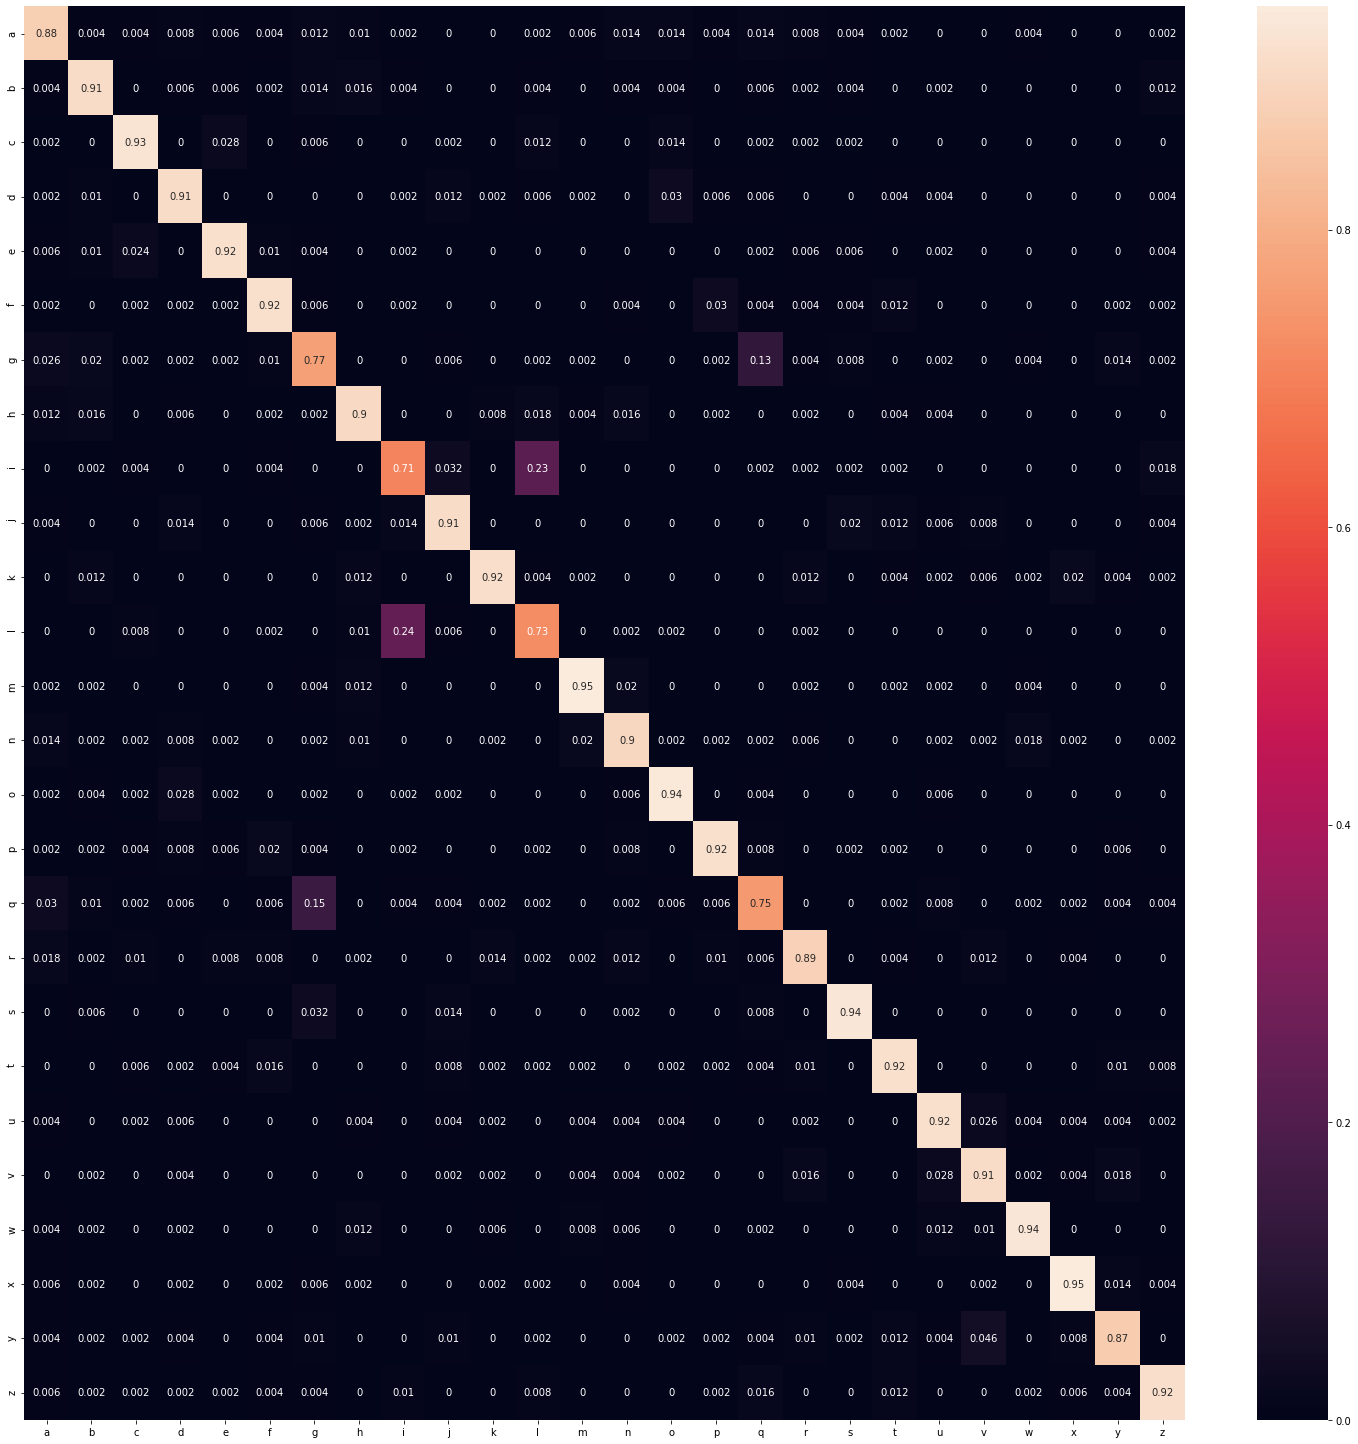

In [32]:
confusion_matrix = pd.DataFrame(matrix/np.sum(matrix) * 26,
                     index = [i for i in tuple(string.ascii_lowercase)],
                     columns = [i for i in tuple(string.ascii_lowercase)])
plt.figure(figsize = (26, 26))
sn.heatmap(confusion_matrix, annot=True)

## Результаты по confusion_matrix

1) Я могу сказать, что моя модель обучилась достаточно равномерно

2) Буквы с наилучшими предсказаниями: x, w, s, o, m . Я думаю, это произошл из-за того, что именно эти буквы больше всего отличаются от других 

3) Буквы с наихудшими предсказаниями: l, i, q, g. Опять же эти буквы очень схожи между собой

## Задание 1.3
Топ букв детектированных с ошибкой

1) i  l

2) g  q

3) y  v

4) s  g

5) d  o

6) m  h

7) g  a

8) q  a

9) u  v

10) a  s

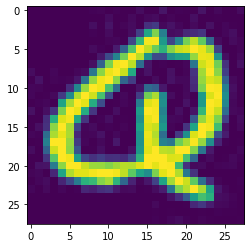

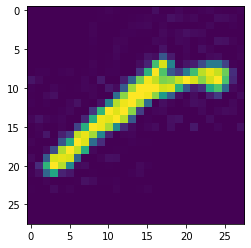

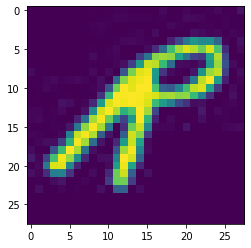

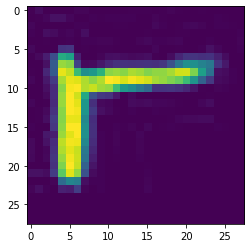

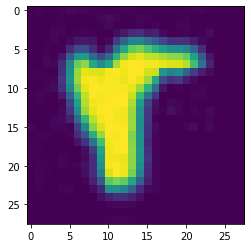

In [45]:
def ret_wrong_preds(y_pred, y_true):
    wrong_preds = list()
    for i in range(len(y_pred)):
        if y_pred[i] != y_true[i]:
            wrong_preds.append(i)
    return wrong_preds

# print(ret_wrong_preds(y_pred, y_true))
wrong_preds = ret_wrong_preds(y_pred, y_true)
for i in wrong_preds[110:115]:
    plt.imshow(val.x[wrong_preds[i]])
    plt.show()


    

## Задание 1.4

### Моя фамилия начинается с буквы о 
### Точность детекции 0.94
###  Чаще всего модель путала с буквами d, n, u

### Задание 2  
  
*Вес в общей оценке - 0.35*  
  
1. Постройте и обучите модели нейронной сети с 1-м, 2-мя и 3-мя сверточными слоями.  
Попробуйте различные значения параметров сверток и числа фильтров на каждом слое. Оцените качество моделей с различными параметрами, проведите сравнительный анализ.  
2. Для наилучшей конфигурации из предыдущего пункта, сравните, как меняется качество модели при увеличении размера батча при использовании BatchNorm и GroupNorm.    

In [15]:
lrs_list = (0.001, 0.1, 0.2)
epochs_list = (10, 15, 20)
batches = (32, 64, 128, 256)

In [21]:
def main_conv_train(model, optimizer, n_epochs, train_dataloader, val_dataloader, device):
    print(model.to(device))
    for epoch in range(1, n_epochs + 1):
        # training
        for x_train, y_train in tqdm(train_dataloader):
            x_train = x_train.unsqueeze(1)
            y_pred = model(x_train)
            # y_pred = y_pred.type(torch.LongTensor)
            loss = F.cross_entropy(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # validation
        if epoch % 2 == 0:
            val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_val, y_val in tqdm(val_dataloader):
                    x_val = x_val.unsqueeze(1)
                    y_pred = model(x_val)
                    loss = F.cross_entropy(y_pred, y_val)
                    val_loss.append(loss.cpu().numpy())
                    val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).cpu().numpy().tolist())
            # print metrics
            print(f"Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}")

def model_conv_train(models, lrs, n_epochs_list, batches, train_data, val_data):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for model in models:
        for lr in lrs:
            print("LR: ", lr)
            layers_optimizer = torch.optim.SGD(model.parameters(), lr=lr)
            for batch in batches:
                print("Batch size: ", batch)
                train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch, shuffle=True, pin_memory=True)
                val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch, shuffle=True, pin_memory=True)
                for n_epochs in n_epochs_list:
                    main_conv_train(model, layers_optimizer, n_epochs, train_loader, val_loader, device)  

In [22]:
model_1_conv_layer = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5), 
    nn.MaxPool2d(kernel_size=4), 
    nn.Flatten(),                 
    nn.Linear(6*6*32, 256),       
    nn.ReLU(),                    
    nn.Linear(256, 26),           
)

model_2_conv_layers = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
    nn.ReLU(), 
    nn.MaxPool2d(kernel_size=2, stride=2), 
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3), 
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2), 
    nn.Flatten(),                 
    nn.Linear(5*5*64, 256),       
    nn.ReLU(),                    
    nn.Linear(256, 26),           
)

model_3_conv_layers = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
    nn.ReLU(), 
    nn.MaxPool2d(kernel_size=2, stride=2), 
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2), 
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2), 
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2), 
    nn.ReLU(),
    nn.Flatten(),                 
    nn.Linear(5*5*64, 256),       
    nn.ReLU(),                    
    nn.Linear(256, 26),           
)

models_with_conv_layers = [model_1_conv_layer, model_2_conv_layers, model_3_conv_layers]

In [23]:
model_conv_train(models_with_conv_layers, lrs_list, epochs_list, batches, train, val)

LR:  0.001
Batch size:  32
Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=1152, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 1.297529697418213, accuracy: 0.6365384615384615


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.9742522835731506, accuracy: 0.7135384615384616


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 0.814809262752533, accuracy: 0.7576923076923077


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 0.6948919892311096, accuracy: 0.7926923076923077


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 0.602088212966919, accuracy: 0.8193846153846154
Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=1152, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.5354117155075073, accuracy: 0.8375384615384616


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.4846789836883545, accuracy: 0.8553076923076923


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 0.440336138010025, accuracy: 0.8665384615384616


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 0.4130636155605316, accuracy: 0.8756923076923077


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 0.3891088664531708, accuracy: 0.8837692307692308


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 12, loss: 0.3682257831096649, accuracy: 0.8867692307692308


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 14, loss: 0.3555021584033966, accuracy: 0.8911538461538462


  0%|          | 0/2032 [00:00<?, ?it/s]

Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=1152, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.3356951177120209, accuracy: 0.8973846153846153


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.32403305172920227, accuracy: 0.8996923076923077


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 0.31324952840805054, accuracy: 0.902


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 0.304688960313797, accuracy: 0.9043076923076923


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 0.30321013927459717, accuracy: 0.9045384615384615


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 12, loss: 0.29362761974334717, accuracy: 0.907


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 14, loss: 0.2880759835243225, accuracy: 0.9079230769230769


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 16, loss: 0.28240105509757996, accuracy: 0.9101538461538462


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 18, loss: 0.27852582931518555, accuracy: 0.9121538461538462


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 20, loss: 0.2739349901676178, accuracy: 0.913
Batch size:  64
Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=1152, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.2717650234699249, accuracy: 0.9143846153846154


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.26738521456718445, accuracy: 0.9160769230769231


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 0.2664574682712555, accuracy: 0.9156923076923077


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 0.2702082693576813, accuracy: 0.9145384615384615


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 0.26476067304611206, accuracy: 0.9162307692307692
Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=1152, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.260684609413147, accuracy: 0.9165384615384615


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.2585992217063904, accuracy: 0.9177692307692308


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 0.25925639271736145, accuracy: 0.9175384615384615


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 0.26133644580841064, accuracy: 0.9182307692307692


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 0.2551676332950592, accuracy: 0.9175384615384615


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 12, loss: 0.2555176317691803, accuracy: 0.917


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 14, loss: 0.25228261947631836, accuracy: 0.9194615384615384


  0%|          | 0/1016 [00:00<?, ?it/s]

Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=1152, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.2514207661151886, accuracy: 0.9183076923076923


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.24995175004005432, accuracy: 0.9193076923076923


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 0.24930104613304138, accuracy: 0.9193076923076923


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 0.24848800897598267, accuracy: 0.9193846153846154


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 0.24729792773723602, accuracy: 0.92


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 12, loss: 0.24630123376846313, accuracy: 0.9197692307692308


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 14, loss: 0.24609775841236115, accuracy: 0.9203846153846154


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 16, loss: 0.24507968127727509, accuracy: 0.9204615384615384


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 18, loss: 0.24480898678302765, accuracy: 0.9206923076923077


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 20, loss: 0.24608372151851654, accuracy: 0.9205384615384615
Batch size:  128
Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=1152, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.24180616438388824, accuracy: 0.9216153846153846


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.2417527735233307, accuracy: 0.9218461538461539


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 0.24144627153873444, accuracy: 0.9220769230769231


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 0.24132023751735687, accuracy: 0.9216923076923077


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 0.24113015830516815, accuracy: 0.9214615384615384
Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=1152, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.24085889756679535, accuracy: 0.9217692307692308


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.23979167640209198, accuracy: 0.9231538461538461


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 0.239108607172966, accuracy: 0.9217692307692308


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 0.24060072004795074, accuracy: 0.9223076923076923


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 0.23955175280570984, accuracy: 0.9220769230769231


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 12, loss: 0.23826834559440613, accuracy: 0.9216923076923077


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 14, loss: 0.23933954536914825, accuracy: 0.9220769230769231


  0%|          | 0/508 [00:00<?, ?it/s]

Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=1152, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.23796308040618896, accuracy: 0.9227692307692308


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.2379685938358307, accuracy: 0.923


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 0.23782174289226532, accuracy: 0.9236923076923077


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 0.2380310297012329, accuracy: 0.9231538461538461


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 0.2363608330488205, accuracy: 0.9236923076923077


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 12, loss: 0.23752863705158234, accuracy: 0.9233846153846154


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 14, loss: 0.23620618879795074, accuracy: 0.9238461538461539


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 16, loss: 0.23535363376140594, accuracy: 0.922923076923077


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 18, loss: 0.23600296676158905, accuracy: 0.9236923076923077


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 20, loss: 0.2355595827102661, accuracy: 0.9233076923076923
Batch size:  256
Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=1152, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 2, loss: 0.2347019910812378, accuracy: 0.9246923076923077


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 4, loss: 0.23506946861743927, accuracy: 0.9236923076923077


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 6, loss: 0.2350640743970871, accuracy: 0.9236153846153846


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 8, loss: 0.2358492612838745, accuracy: 0.9237692307692308


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 10, loss: 0.23480090498924255, accuracy: 0.9240769230769231
Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=1152, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 2, loss: 0.23402610421180725, accuracy: 0.9238461538461539


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 4, loss: 0.2338782101869583, accuracy: 0.9238461538461539


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 6, loss: 0.23411832749843597, accuracy: 0.9244615384615384


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 8, loss: 0.2341919094324112, accuracy: 0.9243076923076923


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 10, loss: 0.23369888961315155, accuracy: 0.9243846153846154


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 12, loss: 0.23434673249721527, accuracy: 0.9244615384615384


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 14, loss: 0.2334749698638916, accuracy: 0.9245384615384615


  0%|          | 0/254 [00:00<?, ?it/s]

Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=1152, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 2, loss: 0.2337975949048996, accuracy: 0.9247692307692308


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 4, loss: 0.2328663021326065, accuracy: 0.925


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 6, loss: 0.23381482064723969, accuracy: 0.924923076923077


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 8, loss: 0.23286770284175873, accuracy: 0.9250769230769231


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 10, loss: 0.23332099616527557, accuracy: 0.9245384615384615


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 12, loss: 0.23337674140930176, accuracy: 0.9253076923076923


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 14, loss: 0.23276099562644958, accuracy: 0.9253846153846154


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 16, loss: 0.23364023864269257, accuracy: 0.9247692307692308


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 18, loss: 0.2329140156507492, accuracy: 0.925


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 20, loss: 0.23245041072368622, accuracy: 0.9247692307692308
LR:  0.1
Batch size:  32
Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=1152, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.29846498370170593, accuracy: 0.9006153846153846


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.23331329226493835, accuracy: 0.9270769230769231


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 0.2504940629005432, accuracy: 0.922923076923077


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 0.35539722442626953, accuracy: 0.9037692307692308


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 0.257681667804718, accuracy: 0.9260769230769231
Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=1152, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.3257945775985718, accuracy: 0.9084615384615384


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.30225759744644165, accuracy: 0.9240769230769231


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 0.30421996116638184, accuracy: 0.9278461538461539


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 0.3417471647262573, accuracy: 0.9164615384615384


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 0.33349424600601196, accuracy: 0.929923076923077


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 12, loss: 0.6115495562553406, accuracy: 0.9069230769230769


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 14, loss: 0.35925811529159546, accuracy: 0.9288461538461539


  0%|          | 0/2032 [00:00<?, ?it/s]

Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=1152, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.43312740325927734, accuracy: 0.9136153846153846


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.38506704568862915, accuracy: 0.9266923076923077


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 0.3934290111064911, accuracy: 0.9270769230769231


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 0.38811612129211426, accuracy: 0.9321538461538461


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 0.4020485579967499, accuracy: 0.932076923076923


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 12, loss: 0.4123321771621704, accuracy: 0.9307692307692308


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 14, loss: 0.42400217056274414, accuracy: 0.9284615384615384


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 16, loss: 0.42274391651153564, accuracy: 0.9328461538461539


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 18, loss: 0.44071465730667114, accuracy: 0.9287692307692308


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 20, loss: 0.4870971143245697, accuracy: 0.916923076923077
Batch size:  64
Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=1152, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.4125272035598755, accuracy: 0.9294615384615385


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.4199027121067047, accuracy: 0.9322307692307692


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 0.4284706115722656, accuracy: 0.930076923076923


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 0.44209155440330505, accuracy: 0.9322307692307692


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 0.44675976037979126, accuracy: 0.9306923076923077
Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=1152, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.45664387941360474, accuracy: 0.9292307692307692


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.4618297517299652, accuracy: 0.9304615384615385


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 0.4746338725090027, accuracy: 0.9292307692307692


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 0.4937520921230316, accuracy: 0.9281538461538461


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 0.48724016547203064, accuracy: 0.9270769230769231


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 12, loss: 0.5101566314697266, accuracy: 0.9297692307692308


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 14, loss: 0.5006147623062134, accuracy: 0.9272307692307692


  0%|          | 0/1016 [00:00<?, ?it/s]

Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=1152, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.5146479606628418, accuracy: 0.9275384615384615


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.5238086581230164, accuracy: 0.9276153846153846


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 0.5313776135444641, accuracy: 0.9297692307692308


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 0.539124608039856, accuracy: 0.9264615384615384


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 0.5397768020629883, accuracy: 0.9270769230769231


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 12, loss: 0.5615525245666504, accuracy: 0.9272307692307692


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 14, loss: 0.5644941329956055, accuracy: 0.9260769230769231


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 16, loss: 0.5596471428871155, accuracy: 0.9264615384615384


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 18, loss: 0.5747129321098328, accuracy: 0.9266153846153846


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 20, loss: 0.5753844976425171, accuracy: 0.9261538461538461
Batch size:  128
Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=1152, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.5844602584838867, accuracy: 0.9266923076923077


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.5954580307006836, accuracy: 0.9257692307692308


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 0.5891446471214294, accuracy: 0.9254615384615384


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 0.5914565920829773, accuracy: 0.9265384615384615


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 0.5942748188972473, accuracy: 0.9265384615384615
Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=1152, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.5991560220718384, accuracy: 0.9264615384615384


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.6004464030265808, accuracy: 0.9263076923076923


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 0.60678631067276, accuracy: 0.9263076923076923


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 0.6068981885910034, accuracy: 0.925923076923077


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 0.6094523668289185, accuracy: 0.9262307692307692


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 12, loss: 0.6137732863426208, accuracy: 0.9261538461538461


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 14, loss: 0.616878092288971, accuracy: 0.9262307692307692


  0%|          | 0/508 [00:00<?, ?it/s]

Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=1152, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.6222880482673645, accuracy: 0.9263076923076923


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.6214512586593628, accuracy: 0.9262307692307692


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 0.6188545823097229, accuracy: 0.9262307692307692


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 0.622395932674408, accuracy: 0.926923076923077


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 0.6259421706199646, accuracy: 0.9266923076923077


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 12, loss: 0.6291470527648926, accuracy: 0.9266923076923077


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 14, loss: 0.6328490972518921, accuracy: 0.9266153846153846


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 16, loss: 0.6329368352890015, accuracy: 0.9263846153846154


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 18, loss: 0.6336042881011963, accuracy: 0.9264615384615384


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 20, loss: 0.6387246251106262, accuracy: 0.9258461538461539
Batch size:  256
Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=1152, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 2, loss: 0.6387571692466736, accuracy: 0.9261538461538461


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 4, loss: 0.6392425298690796, accuracy: 0.9266923076923077


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 6, loss: 0.6433863043785095, accuracy: 0.9265384615384615


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 8, loss: 0.6409977674484253, accuracy: 0.9263846153846154


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 10, loss: 0.6430349349975586, accuracy: 0.9263846153846154
Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=1152, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 2, loss: 0.6419105529785156, accuracy: 0.9264615384615384


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 4, loss: 0.644497811794281, accuracy: 0.9261538461538461


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 6, loss: 0.6435015797615051, accuracy: 0.9263846153846154


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 8, loss: 0.6448197960853577, accuracy: 0.9261538461538461


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 10, loss: 0.6469589471817017, accuracy: 0.9261538461538461


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 12, loss: 0.6490556597709656, accuracy: 0.9264615384615384


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 14, loss: 0.6472227573394775, accuracy: 0.9265384615384615


  0%|          | 0/254 [00:00<?, ?it/s]

Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=1152, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 2, loss: 0.6484246253967285, accuracy: 0.9262307692307692


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 4, loss: 0.6507284045219421, accuracy: 0.9263846153846154


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 6, loss: 0.6499937176704407, accuracy: 0.9262307692307692


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 8, loss: 0.6516793966293335, accuracy: 0.9264615384615384


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 10, loss: 0.6513747572898865, accuracy: 0.9266923076923077


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 12, loss: 0.6528909802436829, accuracy: 0.9265384615384615


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 14, loss: 0.6527448296546936, accuracy: 0.9266923076923077


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 16, loss: 0.6551566123962402, accuracy: 0.9268461538461539


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 18, loss: 0.6537777781486511, accuracy: 0.9268461538461539


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 20, loss: 0.6554834246635437, accuracy: 0.9263846153846154
LR:  0.2
Batch size:  32
Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=1152, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: nan, accuracy: 0.038461538461538464
Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=1152, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 12, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 14, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=1152, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 12, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 14, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 16, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 18, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 20, loss: nan, accuracy: 0.038461538461538464
Batch size:  64
Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=1152, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: nan, accuracy: 0.038461538461538464
Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=1152, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 12, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 14, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=1152, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 12, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 14, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 16, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 18, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 20, loss: nan, accuracy: 0.038461538461538464
Batch size:  128
Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=1152, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: nan, accuracy: 0.038461538461538464
Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=1152, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 12, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 14, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=1152, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 12, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 14, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 16, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 18, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 20, loss: nan, accuracy: 0.038461538461538464
Batch size:  256
Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=1152, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 2, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 4, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 6, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 8, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 10, loss: nan, accuracy: 0.038461538461538464
Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=1152, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 2, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 4, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 6, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 8, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 10, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 12, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 14, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=1152, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 2, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 4, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 6, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 8, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 10, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 12, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 14, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 16, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 18, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 20, loss: nan, accuracy: 0.038461538461538464
LR:  0.001
Batch size:  32
Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1600, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 1.8677369356155396, accuracy: 0.5082307692307693


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 1.1238652467727661, accuracy: 0.6655384615384615


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 0.8901047706604004, accuracy: 0.7307692307692307


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 0.7038208246231079, accuracy: 0.7870769230769231


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 0.5872843265533447, accuracy: 0.8202307692307692
Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1600, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.5037351250648499, accuracy: 0.8436153846153847


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.44898721575737, accuracy: 0.8588461538461538


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 0.4092254936695099, accuracy: 0.8731538461538462


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 0.3817024827003479, accuracy: 0.8823076923076923


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 0.36086124181747437, accuracy: 0.8867692307692308


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 12, loss: 0.34530818462371826, accuracy: 0.8908461538461538


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 14, loss: 0.33075499534606934, accuracy: 0.8966923076923077


  0%|          | 0/2032 [00:00<?, ?it/s]

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1600, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.3100854456424713, accuracy: 0.9014615384615384


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.30799609422683716, accuracy: 0.9020769230769231


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 0.3062742352485657, accuracy: 0.9016153846153846


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 0.2836679220199585, accuracy: 0.9084615384615384


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 0.2759197950363159, accuracy: 0.9127692307692308


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 12, loss: 0.27320176362991333, accuracy: 0.9121538461538462


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 14, loss: 0.28127479553222656, accuracy: 0.9083846153846153


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 16, loss: 0.2711658179759979, accuracy: 0.9132307692307692


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 18, loss: 0.2628173828125, accuracy: 0.9153846153846154


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 20, loss: 0.2588363289833069, accuracy: 0.9175384615384615
Batch size:  64
Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1600, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.25084468722343445, accuracy: 0.921923076923077


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.24918241798877716, accuracy: 0.9192307692307692


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 0.2463826686143875, accuracy: 0.920923076923077


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 0.24425120651721954, accuracy: 0.9215384615384615


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 0.2457989752292633, accuracy: 0.9226923076923077
Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1600, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.24656157195568085, accuracy: 0.9214615384615384


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.24306826293468475, accuracy: 0.9228461538461539


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 0.24063740670681, accuracy: 0.9223846153846154


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 0.24127081036567688, accuracy: 0.921923076923077


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 0.24144485592842102, accuracy: 0.9235384615384615


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 12, loss: 0.2379598468542099, accuracy: 0.923923076923077


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 14, loss: 0.24056729674339294, accuracy: 0.9234615384615384


  0%|          | 0/1016 [00:00<?, ?it/s]

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1600, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.23786646127700806, accuracy: 0.9250769230769231


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.23644132912158966, accuracy: 0.9245384615384615


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 0.2354467809200287, accuracy: 0.9246153846153846


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 0.23476223647594452, accuracy: 0.9245384615384615


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 0.23457448184490204, accuracy: 0.9246153846153846


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 12, loss: 0.23338721692562103, accuracy: 0.9253076923076923


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 14, loss: 0.23378399014472961, accuracy: 0.9234615384615384


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 16, loss: 0.2343938797712326, accuracy: 0.9250769230769231


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 18, loss: 0.23370271921157837, accuracy: 0.9250769230769231


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 20, loss: 0.23040169477462769, accuracy: 0.9260769230769231
Batch size:  128
Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1600, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.22896523773670197, accuracy: 0.926923076923077


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.23038168251514435, accuracy: 0.9260769230769231


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 0.22985070943832397, accuracy: 0.927


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 0.2297152876853943, accuracy: 0.9264615384615384


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 0.22910374402999878, accuracy: 0.9266923076923077
Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1600, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.22932197153568268, accuracy: 0.927


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.2286110818386078, accuracy: 0.9275384615384615


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 0.2299264520406723, accuracy: 0.9270769230769231


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 0.23031097650527954, accuracy: 0.9258461538461539


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 0.22866865992546082, accuracy: 0.926923076923077


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 12, loss: 0.22786487638950348, accuracy: 0.9285384615384615


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 14, loss: 0.22728213667869568, accuracy: 0.9287692307692308


  0%|          | 0/508 [00:00<?, ?it/s]

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1600, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.22869263589382172, accuracy: 0.9283076923076923


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.22958214581012726, accuracy: 0.9274615384615384


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 0.23024150729179382, accuracy: 0.9281538461538461


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 0.229879692196846, accuracy: 0.9273846153846154


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 0.22906188666820526, accuracy: 0.9282307692307692


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 12, loss: 0.22710493206977844, accuracy: 0.929


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 14, loss: 0.22827711701393127, accuracy: 0.9278461538461539


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 16, loss: 0.22845791280269623, accuracy: 0.928


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 18, loss: 0.22762997448444366, accuracy: 0.9265384615384615


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 20, loss: 0.22888679802417755, accuracy: 0.9264615384615384
Batch size:  256
Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1600, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 2, loss: 0.2266656458377838, accuracy: 0.9296153846153846


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 4, loss: 0.22618083655834198, accuracy: 0.93


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 6, loss: 0.2262273132801056, accuracy: 0.9288461538461539


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 8, loss: 0.22824057936668396, accuracy: 0.9281538461538461


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 10, loss: 0.226750910282135, accuracy: 0.9286153846153846
Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1600, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 2, loss: 0.22660906612873077, accuracy: 0.9292307692307692


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 4, loss: 0.22739717364311218, accuracy: 0.9293846153846154


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 6, loss: 0.2271730899810791, accuracy: 0.9293846153846154


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 8, loss: 0.22681565582752228, accuracy: 0.9286923076923077


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 10, loss: 0.22611796855926514, accuracy: 0.9286923076923077


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 12, loss: 0.22644080221652985, accuracy: 0.9276153846153846


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 14, loss: 0.2265588492155075, accuracy: 0.9284615384615384


  0%|          | 0/254 [00:00<?, ?it/s]

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1600, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 2, loss: 0.228739932179451, accuracy: 0.9267692307692308


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 4, loss: 0.22627106308937073, accuracy: 0.928923076923077


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 6, loss: 0.22724275290966034, accuracy: 0.9282307692307692


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 8, loss: 0.22662684321403503, accuracy: 0.9291538461538461


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 10, loss: 0.22755269706249237, accuracy: 0.9283846153846154


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 12, loss: 0.22907330095767975, accuracy: 0.9273846153846154


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 14, loss: 0.22744399309158325, accuracy: 0.9284615384615384


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 16, loss: 0.22671587765216827, accuracy: 0.9286153846153846


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 18, loss: 0.2265092134475708, accuracy: 0.9296923076923077


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 20, loss: 0.22719299793243408, accuracy: 0.928076923076923
LR:  0.1
Batch size:  32
Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1600, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 3.2586445808410645, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 3.2590253353118896, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 3.2584805488586426, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 3.258648633956909, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 3.258777141571045, accuracy: 0.038461538461538464
Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1600, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 3.258528709411621, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 3.258604049682617, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 3.258768081665039, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 3.2587363719940186, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 3.2586259841918945, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 12, loss: 3.258523941040039, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 14, loss: 3.2586941719055176, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1600, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 3.258573055267334, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 3.2588417530059814, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 3.2584636211395264, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 3.2585971355438232, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 3.258763074874878, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 12, loss: 3.2586264610290527, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 14, loss: 3.2585103511810303, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 16, loss: 3.258817195892334, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 18, loss: 3.2587411403656006, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 20, loss: 3.2585995197296143, accuracy: 0.038461538461538464
Batch size:  64
Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1600, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 3.2583630084991455, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 3.258272409439087, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 3.2583158016204834, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 3.25821590423584, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 3.25830078125, accuracy: 0.038461538461538464
Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1600, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 3.258355140686035, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 3.258260726928711, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 3.258249282836914, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 3.2582523822784424, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 3.258280038833618, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 12, loss: 3.2582924365997314, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 14, loss: 3.2582833766937256, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1600, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 3.2582998275756836, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 3.2583508491516113, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 3.2583274841308594, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 3.258357048034668, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 3.2583465576171875, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 12, loss: 3.258284568786621, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 14, loss: 3.25822377204895, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 16, loss: 3.258335590362549, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 18, loss: 3.25822114944458, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 20, loss: 3.25828218460083, accuracy: 0.038461538461538464
Batch size:  128
Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1600, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 3.258143186569214, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 3.258124828338623, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 3.25815486907959, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 3.2581496238708496, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 3.258147954940796, accuracy: 0.038461538461538464
Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1600, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 3.258122444152832, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 3.2581284046173096, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 3.2581562995910645, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 3.2581536769866943, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 3.2581281661987305, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 12, loss: 3.2581489086151123, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 14, loss: 3.2581450939178467, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1600, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 3.2581450939178467, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 3.258120059967041, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 3.2581279277801514, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 3.258178472518921, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 3.258150339126587, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 12, loss: 3.258141279220581, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 14, loss: 3.2581541538238525, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 16, loss: 3.25813364982605, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 18, loss: 3.258159875869751, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 20, loss: 3.258141040802002, accuracy: 0.038461538461538464
Batch size:  256
Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1600, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 2, loss: 3.2581045627593994, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 4, loss: 3.258103847503662, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 6, loss: 3.2581093311309814, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 8, loss: 3.258100986480713, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 10, loss: 3.258103847503662, accuracy: 0.038461538461538464
Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1600, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 2, loss: 3.258100986480713, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 4, loss: 3.2581005096435547, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 6, loss: 3.2581024169921875, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 8, loss: 3.2581050395965576, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 10, loss: 3.258103609085083, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 12, loss: 3.258103609085083, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 14, loss: 3.258103609085083, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1600, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 2, loss: 3.258105516433716, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 4, loss: 3.258100986480713, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 6, loss: 3.258105754852295, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 8, loss: 3.258105754852295, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 10, loss: 3.2581043243408203, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 12, loss: 3.2581050395965576, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 14, loss: 3.2581002712249756, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 16, loss: 3.2581074237823486, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 18, loss: 3.258099317550659, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 20, loss: 3.258108139038086, accuracy: 0.038461538461538464
LR:  0.2
Batch size:  32
Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1600, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 3.2591776847839355, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 3.259742021560669, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 3.259768009185791, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 3.2595131397247314, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 3.260040283203125, accuracy: 0.038461538461538464
Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1600, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 3.2592365741729736, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 3.2591586112976074, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 3.2597415447235107, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 3.2590742111206055, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 3.2590882778167725, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 12, loss: 3.2598819732666016, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 14, loss: 3.2591471672058105, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1600, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 3.259432077407837, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 3.2592456340789795, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 3.259277582168579, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 3.259289264678955, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 3.2590601444244385, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 12, loss: 3.2594003677368164, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 14, loss: 3.259162425994873, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 16, loss: 3.258951425552368, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 18, loss: 3.260075330734253, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 20, loss: 3.25952410697937, accuracy: 0.038461538461538464
Batch size:  64
Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1600, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 3.2590253353118896, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 3.2589099407196045, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 3.2592761516571045, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 3.258810043334961, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 3.2589311599731445, accuracy: 0.038461538461538464
Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1600, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 3.258568286895752, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 3.258535385131836, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 3.258876323699951, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 3.258687973022461, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 3.258734703063965, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 12, loss: 3.2585222721099854, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 14, loss: 3.2589895725250244, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1600, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 3.259000778198242, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 3.2586004734039307, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 3.2589542865753174, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 3.258579730987549, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 3.2589104175567627, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 12, loss: 3.258665084838867, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 14, loss: 3.258819580078125, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 16, loss: 3.258924961090088, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 18, loss: 3.2586560249328613, accuracy: 0.038461538461538464


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 20, loss: 3.2585859298706055, accuracy: 0.038461538461538464
Batch size:  128
Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1600, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 3.2582359313964844, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 3.258242130279541, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 3.258286237716675, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 3.258329153060913, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 3.2582266330718994, accuracy: 0.038461538461538464
Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1600, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 3.2582576274871826, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 3.2582900524139404, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 3.2582664489746094, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 3.258279800415039, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 3.2582387924194336, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 12, loss: 3.2582807540893555, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 14, loss: 3.258190631866455, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1600, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 3.2582831382751465, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 3.2583560943603516, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 3.2582225799560547, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 3.2582898139953613, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 3.2583038806915283, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 12, loss: 3.258251428604126, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 14, loss: 3.2582929134368896, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 16, loss: 3.2582013607025146, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 18, loss: 3.2582478523254395, accuracy: 0.038461538461538464


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 20, loss: 3.258272409439087, accuracy: 0.038461538461538464
Batch size:  256
Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1600, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 2, loss: 3.258127212524414, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 4, loss: 3.25816011428833, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 6, loss: 3.2581489086151123, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 8, loss: 3.258148193359375, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 10, loss: 3.258138656616211, accuracy: 0.038461538461538464
Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1600, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 2, loss: 3.2581331729888916, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 4, loss: 3.2581443786621094, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 6, loss: 3.258134365081787, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 8, loss: 3.258139133453369, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 10, loss: 3.258139133453369, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 12, loss: 3.258134365081787, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 14, loss: 3.2581520080566406, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1600, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 2, loss: 3.258152961730957, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 4, loss: 3.258124351501465, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 6, loss: 3.258146047592163, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 8, loss: 3.2581398487091064, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 10, loss: 3.258129358291626, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 12, loss: 3.2581355571746826, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 14, loss: 3.258136749267578, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 16, loss: 3.2581379413604736, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 18, loss: 3.2581424713134766, accuracy: 0.038461538461538464


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 20, loss: 3.2581186294555664, accuracy: 0.038461538461538464
LR:  0.001
Batch size:  32
Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
  (7): ReLU()
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=1600, out_features=256, bias=True)
  (10): ReLU()
  (11): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 3.185288667678833, accuracy: 0.23784615384615385


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 1.4274554252624512, accuracy: 0.5823846153846154


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 1.0840331315994263, accuracy: 0.6702307692307692


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 0.8684539198875427, accuracy: 0.7365384615384616


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 0.7607349753379822, accuracy: 0.7604615384615384
Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
  (7): ReLU()
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=1600, out_features=256, bias=True)
  (10): ReLU()
  (11): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.6390317678451538, accuracy: 0.8031538461538461


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.5513999462127686, accuracy: 0.8272307692307692


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 0.4899246394634247, accuracy: 0.8465384615384616


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 0.4652422070503235, accuracy: 0.8522307692307692


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 0.4988505244255066, accuracy: 0.8417692307692307


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 12, loss: 0.3945026695728302, accuracy: 0.8757692307692307


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 14, loss: 0.4004890024662018, accuracy: 0.8747692307692307


  0%|          | 0/2032 [00:00<?, ?it/s]

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
  (7): ReLU()
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=1600, out_features=256, bias=True)
  (10): ReLU()
  (11): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: 0.34531423449516296, accuracy: 0.8917692307692308


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: 0.33098578453063965, accuracy: 0.8953846153846153


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: 0.34487923979759216, accuracy: 0.8916923076923077


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: 0.3376629948616028, accuracy: 0.8889230769230769


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: 0.33911266922950745, accuracy: 0.8881538461538462


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 12, loss: 0.31130585074424744, accuracy: 0.9016923076923077


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 14, loss: 0.297634094953537, accuracy: 0.9080769230769231


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 16, loss: 0.29132553935050964, accuracy: 0.9076153846153846


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 18, loss: 0.28335458040237427, accuracy: 0.909923076923077


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 20, loss: 0.29647067189216614, accuracy: 0.9050769230769231
Batch size:  64
Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
  (7): ReLU()
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=1600, out_features=256, bias=True)
  (10): ReLU()
  (11): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.26868459582328796, accuracy: 0.9144615384615384


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.26690924167633057, accuracy: 0.9161538461538462


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 0.2719230353832245, accuracy: 0.9130769230769231


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 0.2651045024394989, accuracy: 0.915923076923077


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 0.26474106311798096, accuracy: 0.916923076923077
Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
  (7): ReLU()
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=1600, out_features=256, bias=True)
  (10): ReLU()
  (11): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.2625248432159424, accuracy: 0.9165384615384615


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.2646157443523407, accuracy: 0.917


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 0.2682686746120453, accuracy: 0.9114615384615384


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 0.25838127732276917, accuracy: 0.918923076923077


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 0.25821125507354736, accuracy: 0.9208461538461539


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 12, loss: 0.2578665018081665, accuracy: 0.9183076923076923


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 14, loss: 0.2545432150363922, accuracy: 0.9196153846153846


  0%|          | 0/1016 [00:00<?, ?it/s]

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
  (7): ReLU()
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=1600, out_features=256, bias=True)
  (10): ReLU()
  (11): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 2, loss: 0.25403255224227905, accuracy: 0.9217692307692308


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 4, loss: 0.2533245384693146, accuracy: 0.9207692307692308


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 6, loss: 0.25599750876426697, accuracy: 0.9230769230769231


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 8, loss: 0.25048449635505676, accuracy: 0.9210769230769231


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 10, loss: 0.2565300762653351, accuracy: 0.9190769230769231


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 12, loss: 0.25694337487220764, accuracy: 0.9196923076923077


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 14, loss: 0.2561279833316803, accuracy: 0.9188461538461539


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 16, loss: 0.25604045391082764, accuracy: 0.9196923076923077


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 18, loss: 0.2514903247356415, accuracy: 0.9226153846153846


  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch: 20, loss: 0.25645774602890015, accuracy: 0.9187692307692308
Batch size:  128
Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
  (7): ReLU()
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=1600, out_features=256, bias=True)
  (10): ReLU()
  (11): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.24985696375370026, accuracy: 0.9213846153846154


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.24516724050045013, accuracy: 0.9236923076923077


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 0.24879081547260284, accuracy: 0.9221538461538461


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 0.24745120108127594, accuracy: 0.923923076923077


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 0.24944818019866943, accuracy: 0.9227692307692308
Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
  (7): ReLU()
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=1600, out_features=256, bias=True)
  (10): ReLU()
  (11): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.24639219045639038, accuracy: 0.9247692307692308


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.2459740936756134, accuracy: 0.9253076923076923


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 0.24747700989246368, accuracy: 0.9241538461538461


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 0.24722589552402496, accuracy: 0.9243846153846154


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 0.24602027237415314, accuracy: 0.9246153846153846


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 12, loss: 0.2473411113023758, accuracy: 0.9256153846153846


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 14, loss: 0.2528808116912842, accuracy: 0.9201538461538461


  0%|          | 0/508 [00:00<?, ?it/s]

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
  (7): ReLU()
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=1600, out_features=256, bias=True)
  (10): ReLU()
  (11): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 2, loss: 0.2495710402727127, accuracy: 0.9233076923076923


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 4, loss: 0.24603396654129028, accuracy: 0.9255384615384615


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 6, loss: 0.24810566008090973, accuracy: 0.9232307692307692


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 8, loss: 0.24736396968364716, accuracy: 0.9245384615384615


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10, loss: 0.2509957551956177, accuracy: 0.9227692307692308


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 12, loss: 0.24953170120716095, accuracy: 0.9233846153846154


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 14, loss: 0.24884893000125885, accuracy: 0.926


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 16, loss: 0.2486816793680191, accuracy: 0.9256923076923077


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 18, loss: 0.24890418350696564, accuracy: 0.9253076923076923


  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 20, loss: 0.2503340244293213, accuracy: 0.9233076923076923
Batch size:  256
Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
  (7): ReLU()
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=1600, out_features=256, bias=True)
  (10): ReLU()
  (11): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 2, loss: 0.24783244729042053, accuracy: 0.924


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 4, loss: 0.24672868847846985, accuracy: 0.9246923076923077


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 6, loss: 0.24548017978668213, accuracy: 0.9256923076923077


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 8, loss: 0.24699825048446655, accuracy: 0.926


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 10, loss: 0.24797961115837097, accuracy: 0.9244615384615384
Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
  (7): ReLU()
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=1600, out_features=256, bias=True)
  (10): ReLU()
  (11): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 2, loss: 0.2474260777235031, accuracy: 0.9257692307692308


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 4, loss: 0.24839666485786438, accuracy: 0.9250769230769231


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 6, loss: 0.24949464201927185, accuracy: 0.9253076923076923


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 8, loss: 0.2472391575574875, accuracy: 0.9250769230769231


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 10, loss: 0.24814721941947937, accuracy: 0.9254615384615384


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 12, loss: 0.24849730730056763, accuracy: 0.9257692307692308


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 14, loss: 0.24969930946826935, accuracy: 0.923923076923077


  0%|          | 0/254 [00:00<?, ?it/s]

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
  (7): ReLU()
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=1600, out_features=256, bias=True)
  (10): ReLU()
  (11): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 2, loss: 0.24812772870063782, accuracy: 0.926


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 4, loss: 0.24817398190498352, accuracy: 0.9263846153846154


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 6, loss: 0.2498777210712433, accuracy: 0.9254615384615384


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 8, loss: 0.2503371238708496, accuracy: 0.9253076923076923


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 10, loss: 0.2491658329963684, accuracy: 0.9246153846153846


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 12, loss: 0.25078311562538147, accuracy: 0.9245384615384615


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 14, loss: 0.25030791759490967, accuracy: 0.925


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 16, loss: 0.24971336126327515, accuracy: 0.925


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 18, loss: 0.2505476176738739, accuracy: 0.9247692307692308


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 20, loss: 0.2504783570766449, accuracy: 0.9260769230769231
LR:  0.1
Batch size:  32
Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
  (7): ReLU()
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=1600, out_features=256, bias=True)
  (10): ReLU()
  (11): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 2, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 4, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 6, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 8, loss: nan, accuracy: 0.038461538461538464


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch: 10, loss: nan, accuracy: 0.038461538461538464
Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
  (7): ReLU()
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=1600, out_features=256, bias=True)
  (10): ReLU()
  (11): Linear(in_features=256, out_features=26, bias=True)
)


  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Результаты

1) Были обучены модели нейронной сети с 1-м, 2-мя и 3-мя сверточными слоями с различными параметрами

2) Лучшим результат, ожидаемо, показала следующая модель с 3-мя сверточными слоями:
  
  LR = 0.001
  
  Batch size = 256
  
  Epoch_num = 10
  
  Accuracy = 0.926

3) В действительности, модели с 1-м и 2-мя сверточными слоями не сильно отстают по результатам, они находятся в пределе 0.92

4) Кроме того, стоит заметить, что увеличение размера батчей немного улучшило результаты
  

### Задание 3    
  
Обучите модель с точностью (accuracy) на тестовых данных:  
- `>= 0.85`    +1 балл
- `>= 0.95`    +2 балла
- `>= 0.99`    +3 балла  

Наилучший Accuracy было достигнуто моделью с 3-мя сверточными слоями  = 0.926

## Бонусные задания

**Задание 1 (1 балл).**  

Напишите на листке белой бумаги (маркером или ручкой) от 5 разных букв (можно больше 5 букв в целом с повторениями, но должно быть минимум 5 разных) английского алфавита (в датасете есть как прописные, так и строчные буквы). Сфотографируйте букву и приведите её картинку к размеру $28\times28$ и, желательно, к чёрно-белой палитре цветов. Передайте получившиеся изображения вашей модели и выполните предсказание, оцените результат.  
  
**Tips:**  
- В датасете все буквы занимают практически всё пространство картинки по высоте или ширине (или вместе). Если ваша буква будет слишком маленькой или большой, это может повлиять на результат детекции.
- Помните, что буква должна быть белого цвета, а фон - чёрного.
- Описание ваших действий при выполнении этого задания (что вы использовали, чтобы привести картинку к нужному виду) категорически приветствуется :)

**Задание 2 (1 балл):**    
  
Используйте transfer learning подход для решения задачи - дообучите какую-либо модель, предобученную на ImageNet, для классификации рукописных букв. Оцените качество решения.  
В качестве предобученой модели можно взять одну из [torchvision models](https://pytorch.org/vision/stable/models.html).

**Задание 3 (1 балл):**  
  
Добавьте вывод значений функции потерь и accuracy в tensorboard.  
Метрики нужно выводить и для обучающей, и для тестовой выборки.